# Proyecto de Machine Learning: Predicción de Demanda de Bicicletas Compartidas

## Objetivo del Proyecto
Desarrollar un modelo de regresión para predecir la demanda de bicicletas compartidas basado en factores climáticos, temporales y estacionales.

## Dataset
- **Fuente**: UCI Machine Learning Repository - Bike Sharing Dataset
- **Instancias**: 17,389 registros
- **Características**: 13 features
- **Tarea**: Regresión
- **Periodo**: 2011-2012

## Fases del Proyecto
1. **Fase 1**: Análisis Exploratorio de Datos (EDA)
2. **Fase 2**: Preprocesamiento y Tratamiento de Datos
3. **Fase 3**: Modelado
4. **Fase 4**: Optimización

---

## Importacion de Librerias

In [1]:
# IMPORTS Y CONFIGURACIÓN GLOBAL PARA REGRESIÓN
# ===============================================

# === LIBRERÍAS BÁSICAS ===
import warnings
import numpy as np
import pandas as pd

# === VISUALIZACIÓN ===
import matplotlib.pyplot as plt
import seaborn as sns

# === DATOS ===
from ucimlrepo import fetch_ucirepo

# === MODELOS DE REGRESIÓN ===
# Support Vector Machine
from sklearn.svm import SVR

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgb

# Redes Neuronales
from sklearn.neural_network import MLPRegressor

# Bagging
from sklearn.ensemble import BaggingRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

# Voting
from sklearn.ensemble import VotingRegressor

# === MÉTRICAS DE REGRESIÓN ===
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# === PREPROCESAMIENTO Y VALIDACIÓN ===
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score,
    KFold
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# === ANÁLISIS ESTADÍSTICO ===
from scipy import stats
import scipy.stats as stats

# === CONFIGURACIÓN GLOBAL ===
# Silenciar warnings no críticos
warnings.filterwarnings('ignore')

# Estilos de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)

print("✅ Librerías para REGRESIÓN importadas y configuración completada")
print("🤖 Modelos disponibles: SVM, Decision Tree, Random Forest, XGBoost, Neural Networks, Bagging, Boosting, Voting")

✅ Librerías para REGRESIÓN importadas y configuración completada
🤖 Modelos disponibles: SVM, Decision Tree, Random Forest, XGBoost, Neural Networks, Bagging, Boosting, Voting


## Definicion de Funciones

In [2]:
def plot_distribution(data, columns, figsize=(15, 10)):
    """
    Visualiza la distribución de variables para análisis de regresión
    """
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma simple para variables numéricas
            axes[i].hist(data[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].grid(alpha=0.3)
            
            # Agregar estadísticas básicas
            mean_val = data[col].mean()
            median_val = data[col].median()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.2f}')
            axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.2f}')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr(numeric_only=True)
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, figsize=(15, 10)):
    """
    Detecta y visualiza outliers en variables numéricas usando boxplots
    """
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Boxplot para detectar outliers
            box_plot = axes[i].boxplot(data[col], patch_artist=True)
            box_plot['boxes'][0].set_facecolor('lightblue')
            axes[i].set_title(f'Outliers en {col}')
            axes[i].set_ylabel(col)
            axes[i].grid(alpha=0.3)
            
            # Calcular y mostrar estadísticas de outliers
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
            
            axes[i].text(0.02, 0.98, f'Outliers: {len(outliers)}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_target_distribution(y, title="Distribución de la Variable Objetivo", figsize=(12, 5)):
    """
    Analiza y visualiza la distribución de la variable objetivo para regresión
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Histograma
    ax1.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title(f'{title} - Histograma')
    ax1.set_xlabel('Valor')
    ax1.set_ylabel('Frecuencia')
    ax1.grid(alpha=0.3)
    
    # Agregar estadísticas
    mean_val = y.mean()
    median_val = y.median()
    ax1.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.2f}')
    ax1.axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.2f}')
    ax1.legend()
    
    # Boxplot
    box_plot = ax2.boxplot(y, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightgreen')
    ax2.set_title(f'{title} - Boxplot')
    ax2.set_ylabel('Valor')
    ax2.grid(alpha=0.3)
    
    # QQ Plot para normalidad
    from scipy import stats
    stats.probplot(y, dist="norm", plot=ax3)
    ax3.set_title(f'{title} - Q-Q Plot')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir estadísticas
    print(f"📊 ESTADÍSTICAS DE LA VARIABLE OBJETIVO:")
    print(f"   • Media: {y.mean():.2f}")
    print(f"   • Mediana: {y.median():.2f}")
    print(f"   • Desviación estándar: {y.std():.2f}")
    print(f"   • Mínimo: {y.min():.2f}")
    print(f"   • Máximo: {y.max():.2f}")
    print(f"   • Rango: {y.max() - y.min():.2f}")
    print(f"   • Asimetría: {y.skew():.2f}")
    print(f"   • Curtosis: {y.kurtosis():.2f}")
    
    # Test de normalidad
    shapiro_stat, shapiro_p = stats.shapiro(y.sample(min(5000, len(y))))
    print(f"   • Test de Shapiro-Wilk (normalidad): p-value = {shapiro_p:.2e}")
    if shapiro_p > 0.05:
        print("     ✅ Los datos siguen una distribución normal")
    else:
        print("     ❌ Los datos NO siguen una distribución normal")

def evaluate_regression_model(model, X_test, y_test, y_pred, model_name):
    """
    Evalúa un modelo de regresión con múltiples métricas
    """
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Calcular métricas adicionales
    mean_y = np.mean(y_test)
    ss_res = np.sum((y_test - y_pred) ** 2)
    ss_tot = np.sum((y_test - mean_y) ** 2)
    adjusted_r2 = 1 - (ss_res / ss_tot) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Adjusted_R²': adjusted_r2,
        'MAPE': mape,
        'predictions': y_pred
    }
    
    return results

def plot_regression_results(models_results, y_test, figsize=(15, 12)):
    """
    Visualiza los resultados de múltiples modelos de regresión
    """
    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            
            # Scatter plot: Valores reales vs predichos
            axes[i].scatter(y_test, y_pred, alpha=0.6, color='blue')
            
            # Línea de referencia perfecta (y = x)
            min_val = min(y_test.min(), y_pred.min())
            max_val = max(y_test.max(), y_pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
            
            axes[i].set_title(f'{model_name}\nR² = {results["R²"]:.3f}, RMSE = {results["RMSE"]:.2f}')
            axes[i].set_xlabel('Valores Reales')
            axes[i].set_ylabel('Valores Predichos')
            axes[i].grid(alpha=0.3)
            
            # Calcular límites iguales para ambos ejes
            all_values = np.concatenate([y_test, y_pred])
            margin = (all_values.max() - all_values.min()) * 0.05
            axes[i].set_xlim(all_values.min() - margin, all_values.max() + margin)
            axes[i].set_ylim(all_values.min() - margin, all_values.max() + margin)
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_residuals_analysis(models_results, y_test, figsize=(15, 12)):
    """
    Análisis de residuos para modelos de regresión
    """
    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            residuals = y_test - y_pred
            
            # Gráfico de residuos vs valores predichos
            axes[i].scatter(y_pred, residuals, alpha=0.6, color='green')
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8)
            axes[i].set_title(f'Residuos - {model_name}')
            axes[i].set_xlabel('Valores Predichos')
            axes[i].set_ylabel('Residuos')
            axes[i].grid(alpha=0.3)
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def compare_models_metrics(models_results, figsize=(12, 8)):
    """
    Compara las métricas de diferentes modelos de regresión
    """
    # Crear DataFrame con las métricas
    metrics_data = []
    for model_name, results in models_results.items():
        metrics_data.append({
            'Model': model_name,
            'R²': results['R²'],
            'RMSE': results['RMSE'],
            'MAE': results['MAE'],
            'MAPE': results['MAPE']
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Visualizar métricas
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # R²
    axes[0, 0].bar(df_metrics['Model'], df_metrics['R²'], color='skyblue')
    axes[0, 0].set_title('R² Score')
    axes[0, 0].set_ylabel('R²')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # RMSE
    axes[0, 1].bar(df_metrics['Model'], df_metrics['RMSE'], color='lightcoral')
    axes[0, 1].set_title('Root Mean Square Error')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # MAE
    axes[1, 0].bar(df_metrics['Model'], df_metrics['MAE'], color='lightgreen')
    axes[1, 0].set_title('Mean Absolute Error')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # MAPE
    axes[1, 1].bar(df_metrics['Model'], df_metrics['MAPE'], color='gold')
    axes[1, 1].set_title('Mean Absolute Percentage Error')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_metrics

# FASE 1: ANÁLISIS EXPLORATORIO DE DATOS

## 1.1 Carga del Dataset

In [3]:
# 1.1 Carga de datos desde UCI ML Repository

# Obtener el dataset
bike_sharing = fetch_ucirepo(id=275)

# Extraer características y variable objetivo
X = bike_sharing.data.features
y = bike_sharing.data.targets

# Combinar en un solo DataFrame para el análisis
df = pd.concat([X, y], axis=1)

print(f"✅ Dataset cargado exitosamente!")
print(f"📈 Forma del dataset: {df.shape}")
print(f"🔗 Variables de entrada: {X.shape[1]}")
print(f"🎯 Variables objetivo: {y.shape[1]}")

✅ Dataset cargado exitosamente!
📈 Forma del dataset: (17379, 14)
🔗 Variables de entrada: 13
🎯 Variables objetivo: 1


In [4]:
drop_cols = ['dteday']
df = df.drop(columns=drop_cols)
print(f"Existen un total de {df.shape[1]} columnas después de eliminar las columnas innecesarias.")

Existen un total de 13 columnas después de eliminar las columnas innecesarias.


## 1.2 Exploración inicial del dataset

In [ ]:
# 1.2 Exploración inicial del dataset
print("🔍 EXPLORACIÓN INICIAL DEL DATASET")
print("=" * 50)

# Información general del dataset
print("📊 Información general:")
print(f"Forma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")

### 1.2.1 Primeras 5 filas del dataset

In [ ]:
print("\n📋 Primeras 5 filas del dataset:")
display(df.head())

### 1.2.2 Ultimas 5 filas del dataset

In [ ]:
print("\n📋 Últimas 5 filas del dataset:")
display(df.tail())

### 1.2.3 Nombres de las columnas

In [ ]:
print("\n🔗 Nombres de las columnas:")
print(df.columns.tolist())

## 1.3 Análisis de tipos de datos y valores faltantes

### 1.3.1 Información detallada del dataset

In [ ]:
# 1.3 Análisis de tipos de datos y valores faltantes
print("🔍 ANÁLISIS DE TIPOS DE DATOS Y CALIDAD")
print("=" * 50)

# Información detallada del dataset
print("📊 Información detallada:")
df.info()

### 1.3.2 Tipos de datos

In [ ]:
print("\n🔢 Tipos de datos:")
print(df.dtypes)

### 1.3.3 Valores nulos del dataset

In [ ]:
print("\n❌ Valores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
})
print(missing_df)

print(f"\n📈 Total de valores faltantes: {df.isnull().sum().sum()}")
print(f"📊 Porcentaje total de valores faltantes: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

## 1.4 Estadísticas descriptivas

### 1.4.1 Estadísticas para variables numéricas

In [ ]:
# 1.4 Estadísticas descriptivas
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)

variables_numericas = ['temp','atemp','hum','windspeed','cnt']
# Estadísticas para variables numéricas
print("🔢 Variables numéricas:")
print(f"Columnas numéricas: {variables_numericas}")

print("\n📈 Estadísticas descriptivas de variables numéricas:")
display(df[variables_numericas].describe().round(4))

### 1.4.2 Estadísticas para variables OBJECT

In [ ]:
# Estadísticas para variables categóricas
print("\n🏷️ Variables categóricas:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas: {categorical_cols}")

if categorical_cols:
    print("\n📊 Estadísticas descriptivas de variables categóricas:")
    display(df[categorical_cols].describe())
else:
    print("No hay variables categóricas de tipo object en el dataset.")

### 1.4.3 Información sobre la variable objetivo

In [ ]:
# Información sobre la variable objetivo
print("\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (cnt - Total Rental Bikes)")
print(f"Media: {df['cnt'].mean():.2f}")
print(f"Mediana: {df['cnt'].median():.2f}")
print(f"Desviación estándar: {df['cnt'].std():.2f}")
print(f"Mínimo: {df['cnt'].min()}")
print(f"Máximo: {df['cnt'].max()}")
print(f"Rango: {df['cnt'].max() - df['cnt'].min()}")

## 1.5 Análisis de correlaciones

In [ ]:
# 1.5 Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

# Análisis específico entre temperatura y temperatura aparente
print(f"\n🌡️ CORRELACIÓN TEMPERATURA vs TEMPERATURA APARENTE: {correlation_matrix.loc['temp', 'atemp']:.3f}")
print("Esto indica una relación muy fuerte, se puede considerar usar solo una de estas variables.")

## 1.6 Detección y Análisis de Outliers

In [ ]:
### 1.6 Identifique y reporte outliers en al menos 3 variables numéricas
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

main_features = ['temp', 'atemp', 'hum', 'windspeed']

outliers_info = detect_outliers_iqr(df, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")

In [ ]:
# Visualización de outliers usando nuestras funciones
print("\n📊 VISUALIZACIÓN DE OUTLIERS:")

# Variables numéricas principales para análisis de outliers
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']

# Usar la función plot_outliers definida anteriormente
plot_outliers(df, numeric_features, figsize=(18, 12))

## 1.7 Análisis de Distribuciones de Variables Numéricas

In [ ]:
# 1.7 Análisis de distribuciones de variables numéricas
print("📈 ANÁLISIS DE DISTRIBUCIONES")
print("=" * 50)

# Variables numéricas para analizar
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Usar función para mostrar distribuciones
plot_distribution(df, numeric_vars, figsize=(18, 12))

# Análisis específico de la variable objetivo
print("\n🎯 ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO (cnt):")
plot_target_distribution(df['cnt'], title="Demanda de Bicicletas (cnt)", figsize=(15, 5))

## 1.8 Análisis Temporal de la Demanda

In [ ]:
# 1.8 Análisis temporal de la demanda
print("⏰ ANÁLISIS TEMPORAL DE LA DEMANDA")
print("=" * 50)

# Crear mapeos para mejor interpretación
season_names = {1: 'Primavera', 2: 'Verano', 3: 'Otoño', 4: 'Invierno'}
weather_names = {1: 'Despejado', 2: 'Nublado', 3: 'Lluvia ligera', 4: 'Lluvia fuerte'}
year_names = {0: '2011', 1: '2012'}
weekday_names = {0: 'Domingo', 1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sábado'}
workingday_names = {0: 'No laborable', 1: 'Laborable'}
holiday_names = {0: 'No festivo', 1: 'Festivo'}

# Análisis por estación del año
print("\n🌸 DEMANDA PROMEDIO POR ESTACIÓN:")
season_avg = df.groupby('season')['cnt'].mean().sort_values(ascending=False)
for season_code, avg_demand in season_avg.items():
    print(f"• {season_names[season_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por año
print("\n📅 DEMANDA PROMEDIO POR AÑO:")
year_avg = df.groupby('yr')['cnt'].mean()
for year_code, avg_demand in year_avg.items():
    print(f"• {year_names[year_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por día de la semana
print("\n📆 DEMANDA PROMEDIO POR DÍA DE LA SEMANA:")
weekday_avg = df.groupby('weekday')['cnt'].mean()
for weekday_code, avg_demand in weekday_avg.items():
    print(f"• {weekday_names[weekday_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por hora del día
print("\n🕐 DEMANDA PROMEDIO POR HORA DEL DÍA:")
hourly_avg = df.groupby('hr')['cnt'].mean()
print(f"Hora con mayor demanda: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.1f} bicicletas)")
print(f"Hora con menor demanda: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.1f} bicicletas)")

# Análisis por mes
print("\n📊 DEMANDA PROMEDIO POR MES:")
monthly_avg = df.groupby('mnth')['cnt'].mean()
print(f"Mes con mayor demanda: {monthly_avg.idxmax()} ({monthly_avg.max():.1f} bicicletas/hora)")
print(f"Mes con menor demanda: {monthly_avg.idxmin()} ({monthly_avg.min():.1f} bicicletas/hora)")

# Análisis días laborables vs no laborables
print("\n💼 DEMANDA: DÍAS LABORABLES VS NO LABORABLES:")
workingday_comparison = df.groupby('workingday')['cnt'].agg(['mean', 'std', 'count'])
for workingday_code in workingday_comparison.index:
    stats = workingday_comparison.loc[workingday_code]
    print(f"• {workingday_names[workingday_code]}: {stats['mean']:.1f} ± {stats['std']:.1f} bicicletas/hora (n={stats['count']})")

# Análisis condiciones climáticas
print("\n🌤️ DEMANDA PROMEDIO POR CONDICIONES CLIMÁTICAS:")
weather_avg = df.groupby('weathersit')['cnt'].mean().sort_values(ascending=False)
for weather_code, avg_demand in weather_avg.items():
    print(f"• {weather_names[weather_code]}: {avg_demand:.1f} bicicletas/hora")

In [ ]:
# Visualizaciones temporales
print("\n📊 VISUALIZACIONES TEMPORALES:")

# Crear visualizaciones en una sola figura
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Demanda por estación
season_avg.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Demanda Promedio por Estación')
axes[0, 0].set_xlabel('Estación')
axes[0, 0].set_ylabel('Demanda Promedio')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Demanda por hora del día
hourly_avg.plot(kind='line', ax=axes[0, 1], color='orange', marker='o')
axes[0, 1].set_title('Patrón de Demanda por Hora del Día')
axes[0, 1].set_xlabel('Hora del Día')
axes[0, 1].set_ylabel('Demanda Promedio')
axes[0, 1].grid(True, alpha=0.3)

# 3. Demanda por día de la semana
weekday_avg.plot(kind='bar', ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Demanda Promedio por Día de la Semana')
axes[0, 2].set_xlabel('Día de la Semana')
axes[0, 2].set_ylabel('Demanda Promedio')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Demanda por mes
monthly_avg.plot(kind='line', ax=axes[1, 0], color='red', marker='s')
axes[1, 0].set_title('Demanda Promedio por Mes')
axes[1, 0].set_xlabel('Mes')
axes[1, 0].set_ylabel('Demanda Promedio')
axes[1, 0].grid(True, alpha=0.3)

# 5. Comparación días laborables
workingday_comparison['mean'].plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
axes[1, 1].set_title('Días Laborables vs No Laborables')
axes[1, 1].set_xlabel('Tipo de Día')
axes[1, 1].set_ylabel('Demanda Promedio')
axes[1, 1].tick_params(axis='x', rotation=0)

# 6. Condiciones climáticas
weather_avg.plot(kind='bar', ax=axes[1, 2], color='teal')
axes[1, 2].set_title('Demanda por Condiciones Climáticas')
axes[1, 2].set_xlabel('Condición Climática')
axes[1, 2].set_ylabel('Demanda Promedio')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 1.9 Análisis de Relaciones: Variables Climáticas vs Demanda

In [ ]:
# 1.9 Análisis de relaciones entre variables climáticas y demanda
print("🌡️ ANÁLISIS DE RELACIONES CLIMÁTICAS VS DEMANDA")
print("=" * 50)

# Crear gráficos de dispersión para variables climáticas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Temperatura vs Demanda
axes[0, 0].scatter(df['temp'], df['cnt'], alpha=0.5, color='red')
axes[0, 0].set_title('Temperatura vs Demanda')
axes[0, 0].set_xlabel('Temperatura Normalizada')
axes[0, 0].set_ylabel('Demanda (cnt)')
axes[0, 0].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['temp'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['temp'], p(df['temp']), "r--", alpha=0.8)

# 2. Humedad vs Demanda
axes[0, 1].scatter(df['hum'], df['cnt'], alpha=0.5, color='blue')
axes[0, 1].set_title('Humedad vs Demanda')
axes[0, 1].set_xlabel('Humedad Normalizada')
axes[0, 1].set_ylabel('Demanda (cnt)')
axes[0, 1].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['hum'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['hum'], p(df['hum']), "b--", alpha=0.8)

# 3. Velocidad del viento vs Demanda
axes[1, 0].scatter(df['windspeed'], df['cnt'], alpha=0.5, color='green')
axes[1, 0].set_title('Velocidad del Viento vs Demanda')
axes[1, 0].set_xlabel('Velocidad del Viento Normalizada')
axes[1, 0].set_ylabel('Demanda (cnt)')
axes[1, 0].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['windspeed'], df['cnt'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['windspeed'], p(df['windspeed']), "g--", alpha=0.8)

# 4. Temperatura aparente vs Demanda
axes[1, 1].scatter(df['atemp'], df['cnt'], alpha=0.5, color='orange')
axes[1, 1].set_title('Temperatura Aparente vs Demanda')
axes[1, 1].set_xlabel('Temperatura Aparente Normalizada')
axes[1, 1].set_ylabel('Demanda (cnt)')
axes[1, 1].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['atemp'], df['cnt'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['atemp'], p(df['atemp']), "orange", linestyle="--", alpha=0.8)

plt.tight_layout()
plt.show()

# Análisis cuantitativo de las relaciones
print("\n📊 ANÁLISIS CUANTITATIVO DE RELACIONES CLIMÁTICAS:")
print(f"• Correlación Temperatura-Demanda: {df['temp'].corr(df['cnt']):.3f}")
print(f"• Correlación Humedad-Demanda: {df['hum'].corr(df['cnt']):.3f}")
print(f"• Correlación Viento-Demanda: {df['windspeed'].corr(df['cnt']):.3f}")
print(f"• Correlación Temp.Aparente-Demanda: {df['atemp'].corr(df['cnt']):.3f}")

# Análisis por rangos de temperatura
print("\n🌡️ ANÁLISIS POR RANGOS DE TEMPERATURA:")
df['temp_range'] = pd.cut(df['temp'], bins=4, labels=['Baja', 'Media-Baja', 'Media-Alta', 'Alta'])
temp_range_analysis = df.groupby('temp_range')['cnt'].agg(['mean', 'count'])
for temp_range in temp_range_analysis.index:
    stats = temp_range_analysis.loc[temp_range]
    print(f"• Temperatura {temp_range}: {stats['mean']:.1f} bicicletas/hora (n={stats['count']})")

# Análisis por rangos de humedad
print("\n💧 ANÁLISIS POR RANGOS DE HUMEDAD:")
df['hum_range'] = pd.cut(df['hum'], bins=4, labels=['Baja', 'Media-Baja', 'Media-Alta', 'Alta'])
hum_range_analysis = df.groupby('hum_range')['cnt'].agg(['mean', 'count'])
for hum_range in hum_range_analysis.index:
    stats = hum_range_analysis.loc[hum_range]
    print(f"• Humedad {hum_range}: {stats['mean']:.1f} bicicletas/hora (n={stats['count']})")

# Limpiar columnas temporales
df = df.drop(['temp_range', 'hum_range'], axis=1)

In [ ]:
df.shape

---

# FASE 2: PREPROCESAMIENTO Y TRATAMIENTO DE DATOS

## Próximos pasos basados en el EDA:
1. **Tratamiento de multicolinealidad**: Eliminar `atemp` debido a alta correlación con `temp` (r=0.988)
2. **Análisis de outliers**: Decidir tratamiento para outliers en `windspeed` y `holiday`
3. **Ingeniería de características**: Crear features temporales adicionales
4. **Normalización**: Aplicar escalado a variables numéricas si es necesario
5. **División del dataset**: Train/Test split con estratificación temporal

## 2.1 Tratamiento de Multicolinealidad

In [5]:
# 2.1 Tratamiento de Multicolinealidad
print("🔗 TRATAMIENTO DE MULTICOLINEALIDAD")
print("=" * 50)

# Verificar si atemp existe antes de eliminarla
if 'atemp' in df.columns:
    df = df.drop(columns=['atemp'])
    print(f"✅ Variable 'atemp' eliminada por multicolinealidad con 'atemp'")
else:
    print(f"ℹ️ Variable 'atemp' ya había sido eliminada previamente")

print(f"📊 Forma actual del dataset: {df.shape}")
print(f"🔗 Variables disponibles: {list(df.columns)}")

🔗 TRATAMIENTO DE MULTICOLINEALIDAD
✅ Variable 'atemp' eliminada por multicolinealidad con 'atemp'
📊 Forma actual del dataset: (17379, 12)
🔗 Variables disponibles: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']


## 2.2 Análisis de Outliers

In [6]:
def analyze_outliers(df, columns):
    """
    Analiza outliers usando el método IQR y proporciona estadísticas detalladas
    """
    outliers_summary = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identificar outliers
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers_count = outliers_mask.sum()
        outliers_percentage = (outliers_count / len(df)) * 100
        
        outliers_summary.append({
            'Variable': col,
            'Total_Outliers': outliers_count,
            'Porcentaje': outliers_percentage,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Límite_Inferior': lower_bound,
            'Límite_Superior': upper_bound,
            'Min_Outlier': df[outliers_mask][col].min() if outliers_count > 0 else None,
            'Max_Outlier': df[outliers_mask][col].max() if outliers_count > 0 else None
        })
    
    return pd.DataFrame(outliers_summary)

In [7]:
# 2.2 Análisis detallado de outliers en variables numéricas
print("⚠️ ANÁLISIS DETALLADO DE OUTLIERS")
print("=" * 50)

# Variables numéricas para análisis de outliers
numeric_variables = ['temp', 'hum', 'windspeed']

# Realizar análisis de outliers
outliers_df = analyze_outliers(df, numeric_variables)
display(outliers_df)

print("\n📊 RESUMEN DE OUTLIERS:")
for _, row in outliers_df.iterrows():
    print(f"• {row['Variable']}: {row['Total_Outliers']} outliers ({row['Porcentaje']:.2f}%)")
    if row['Total_Outliers'] > 0:
        print(f"  - Rango normal: [{row['Límite_Inferior']:.3f}, {row['Límite_Superior']:.3f}]")
        print(f"  - Outliers van de {row['Min_Outlier']:.3f} a {row['Max_Outlier']:.3f}")
    print()

⚠️ ANÁLISIS DETALLADO DE OUTLIERS


,Variable,Total_Outliers,Porcentaje,Q1,Q3,IQR,Límite_Inferior,Límite_Superior,Min_Outlier,Max_Outlier
0,temp,0,0.000000,0.3400,0.6600,0.3200,-0.1400,1.1400,NaN,NaN
1,hum,22,0.126590,0.4800,0.7800,0.3000,0.0300,1.2300,0.0000,0.0000
2,windspeed,342,1.967892,0.1045,0.2537,0.1492,-0.1193,0.4775,0.4925,0.8507



📊 RESUMEN DE OUTLIERS:
• temp: 0 outliers (0.00%)

• hum: 22 outliers (0.13%)
  - Rango normal: [0.030, 1.230]
  - Outliers van de 0.000 a 0.000

• windspeed: 342 outliers (1.97%)
  - Rango normal: [-0.119, 0.477]
  - Outliers van de 0.492 a 0.851



## 2.3 Tratamiento de Outliers

In [8]:
def cap_outliers(df, column, method='iqr'):
    """
    Aplica capping a outliers usando el método IQR
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Contar outliers antes del tratamiento
    outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    # Aplicar capping
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    # Contar outliers después del tratamiento
    outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    return outliers_before, outliers_after

In [9]:
# 2.3 Tratamiento de Outliers
print("🔧 TRATAMIENTO DE OUTLIERS")
print("=" * 50)

# Crear una copia del dataset original para comparación
df_original = df.copy()

# Decisión de tratamiento basada en el análisis
print("📋 ESTRATEGIA DE TRATAMIENTO:")

# 1. Humedad: Solo 22 outliers (0.13%) - aplicar capping
if 'hum' in df.columns:
    before, after = cap_outliers(df, 'hum')
    print(f"✅ Humedad: {before} → {after} outliers (aplicado capping)")

# 2. Windspeed: 342 outliers (1.97%) - aplicar capping
if 'windspeed' in df.columns:
    before, after = cap_outliers(df, 'windspeed')
    print(f"✅ Velocidad del viento: {before} → {after} outliers (aplicado capping)")

# 3. Variable objetivo (cnt): NO tratar outliers ya que son valores reales de demanda
print(f"ℹ️ Variable objetivo (cnt): Outliers conservados (son valores reales de demanda alta)")

# 4. Temperatura: Sin outliers
print(f"ℹ️ Temperatura: Sin outliers detectados")

print(f"\n📊 Forma del dataset después del tratamiento: {df.shape}")

# Comparar estadísticas antes y después
print("\n📈 COMPARACIÓN ANTES/DESPUÉS DEL TRATAMIENTO:")
for col in ['hum', 'windspeed']:
    if col in df.columns:
        print(f"\n{col.upper()}:")
        print(f"  Antes  - Min: {df_original[col].min():.3f}, Max: {df_original[col].max():.3f}")
        print(f"  Después - Min: {df[col].min():.3f}, Max: {df[col].max():.3f}")

🔧 TRATAMIENTO DE OUTLIERS
📋 ESTRATEGIA DE TRATAMIENTO:
✅ Humedad: 22 → 0 outliers (aplicado capping)
✅ Velocidad del viento: 342 → 0 outliers (aplicado capping)
ℹ️ Variable objetivo (cnt): Outliers conservados (son valores reales de demanda alta)
ℹ️ Temperatura: Sin outliers detectados

📊 Forma del dataset después del tratamiento: (17379, 12)

📈 COMPARACIÓN ANTES/DESPUÉS DEL TRATAMIENTO:

HUM:
  Antes  - Min: 0.000, Max: 1.000
  Después - Min: 0.030, Max: 1.000

WINDSPEED:
  Antes  - Min: 0.000, Max: 0.851
  Después - Min: 0.000, Max: 0.477


## 2.4 Ingeniería de Características

### 2.4.1 Características Temporales Cíclicas

In [10]:
# 2.4 Ingeniería de Características
print("🔧 INGENIERÍA DE CARACTERÍSTICAS")
print("=" * 50)

# Crear una copia para trabajar con características
df_features = df.copy()

print("📝 CREANDO NUEVAS CARACTERÍSTICAS:")

# 1. Características temporales cíclicas
print("\n🕐 Características temporales cíclicas:")

# Hora del día como característica cíclica
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hr'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hr'] / 24)
print("✅ hour_sin, hour_cos - Representación cíclica de la hora")

# Mes como característica cíclica
df_features['month_sin'] = np.sin(2 * np.pi * df_features['mnth'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['mnth'] / 12)
print("✅ month_sin, month_cos - Representación cíclica del mes")

# Día de la semana como característica cíclica
df_features['weekday_sin'] = np.sin(2 * np.pi * df_features['weekday'] / 7)
df_features['weekday_cos'] = np.cos(2 * np.pi * df_features['weekday'] / 7)
print("✅ weekday_sin, weekday_cos - Representación cíclica del día de semana")

🔧 INGENIERÍA DE CARACTERÍSTICAS
📝 CREANDO NUEVAS CARACTERÍSTICAS:

🕐 Características temporales cíclicas:
✅ hour_sin, hour_cos - Representación cíclica de la hora
✅ month_sin, month_cos - Representación cíclica del mes
✅ weekday_sin, weekday_cos - Representación cíclica del día de semana


### 2.4.2 Características de Interacción Climática

In [11]:
# 2. Características de interacción climática
print("\n🌡️ Características de interacción climática:")

# Índice de comodidad térmica (temperatura ajustada por humedad)
df_features['thermal_comfort'] = df_features['temp'] * (1 - df_features['hum'] * 0.5)
print("✅ thermal_comfort - Índice de comodidad térmica")

# Interacción temperatura-velocidad del viento (sensación térmica)
df_features['wind_chill'] = df_features['temp'] * (1 - df_features['windspeed'] * 0.3)
print("✅ wind_chill - Sensación térmica ajustada por viento")


🌡️ Características de interacción climática:
✅ thermal_comfort - Índice de comodidad térmica
✅ wind_chill - Sensación térmica ajustada por viento


### 2.4.3 Características categóricas binarias

In [12]:
# 3. Características categóricas binarias
print("\n🏷️ Características categóricas mejoradas:")

# Horas pico (rush hours)
df_features['is_rush_hour'] = ((df_features['hr'] >= 7) & (df_features['hr'] <= 9) | 
                              (df_features['hr'] >= 17) & (df_features['hr'] <= 19)).astype(int)
print("✅ is_rush_hour - Indicador de horas pico")

# Fin de semana
df_features['is_weekend'] = (df_features['weekday'].isin([0, 6])).astype(int)
print("✅ is_weekend - Indicador de fin de semana")

# Estación cálida (primavera-verano)
df_features['is_warm_season'] = (df_features['season'].isin([1, 2])).astype(int)
print("✅ is_warm_season - Indicador de estación cálida")

# Buenas condiciones climáticas
df_features['good_weather'] = (df_features['weathersit'] == 1).astype(int)
print("✅ good_weather - Indicador de buen clima")


🏷️ Características categóricas mejoradas:
✅ is_rush_hour - Indicador de horas pico
✅ is_weekend - Indicador de fin de semana
✅ is_warm_season - Indicador de estación cálida
✅ good_weather - Indicador de buen clima


In [13]:
df_features.drop(columns=['hr', 'mnth', 'weekday'], inplace=True)
print("ℹ️ Columnas hr, mnth, weekday eliminadas para evitar redundancia")

ℹ️ Columnas hr, mnth, weekday eliminadas para evitar redundancia


### 2.4.5 Comparacion de Nuevos Features

In [14]:
print(f"\n📊 Dataset original: {df.shape}")
print(f"📊 Dataset con nuevas características: {df_features.shape}")
print(f"🆕 Nuevas características añadidas: {df_features.shape[1] - df.shape[1]}")

print(f"\n🔗 Nuevas variables creadas:")
new_features = [col for col in df_features.columns if col not in df.columns]
for feature in new_features:
    print(f"  • {feature}")

# Actualizar el dataset principal
df = df_features.copy()


📊 Dataset original: (17379, 12)
📊 Dataset con nuevas características: (17379, 21)
🆕 Nuevas características añadidas: 9

🔗 Nuevas variables creadas:
  • hour_sin
  • hour_cos
  • month_sin
  • month_cos
  • weekday_sin
  • weekday_cos
  • thermal_comfort
  • wind_chill
  • is_rush_hour
  • is_weekend
  • is_warm_season
  • good_weather


In [15]:
df.columns.tolist()

['season',
 'yr',
 'holiday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'cnt',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'thermal_comfort',
 'wind_chill',
 'is_rush_hour',
 'is_weekend',
 'is_warm_season',
 'good_weather']

---

# FASE 3: MODELADO Y EVALUACIÓN

## 3.1 Preparación para Modelado

### 🎯 **ESTRATEGIA DE MODELADO**
Con el dataset optimizado, procederemos a entrenar múltiples modelos de regresión para comparar su rendimiento:

**Modelos a evaluar:**
1. **Support Vector Machine (SVM)**
2. **Decision Tree**
3. **Random Forest**
4. **XGBoost**
5. **Redes Neuronales (MLP)**
6. **Bagging**
7. **Gradient Boosting**
8. **Voting Regressor**

### ⚡ **VENTAJAS DEL DATASET ACTUAL**
- **Dimensionalidad optimizada**: Entrenamiento más rápido
- **Características relevantes**: Mayor precisión
- **Sin multicolinealidad**: Estabilidad en SVM y redes neuronales
- **Calidad de datos**: Excelente para todos los modelos

🔗 ANÁLISIS DE CORRELACIONES


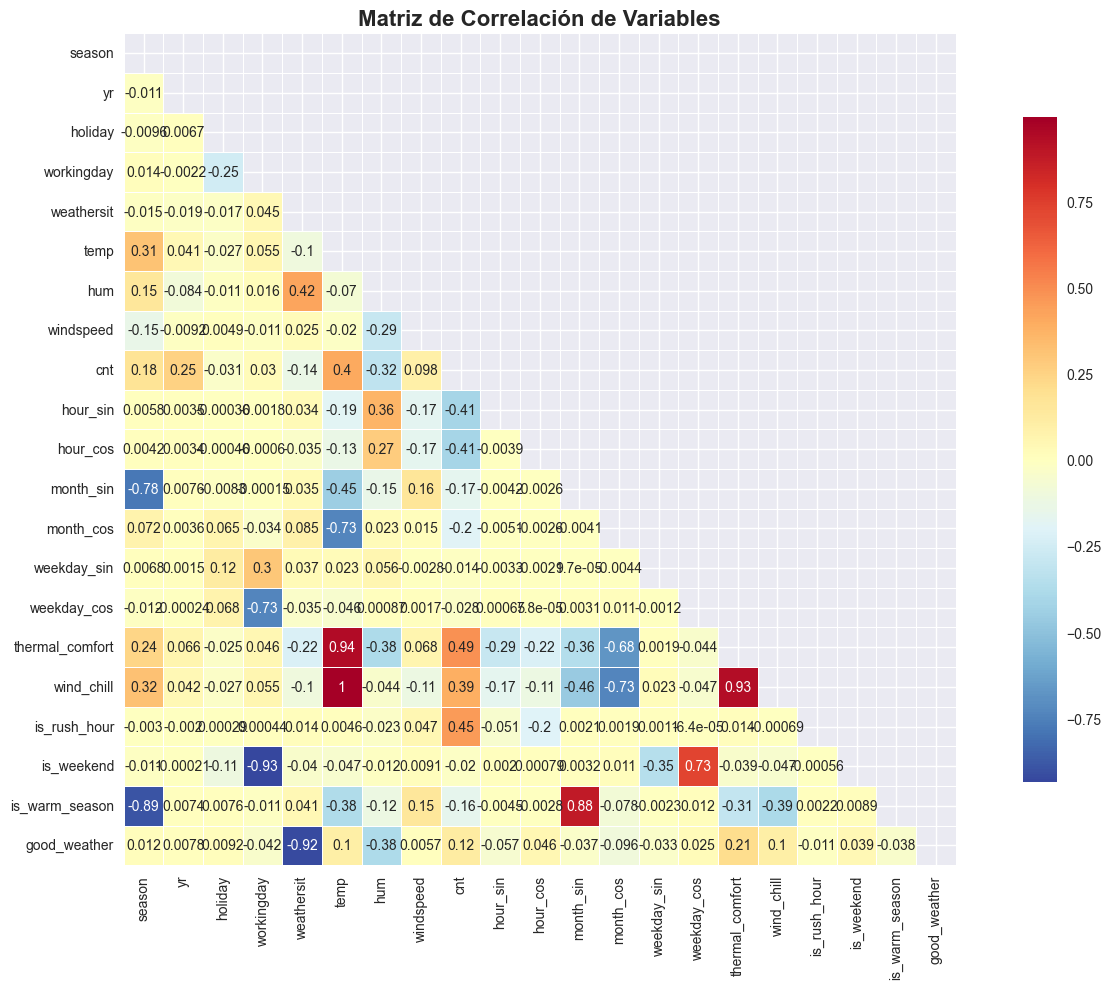


🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):
cnt                1.000000
thermal_comfort    0.487107
is_rush_hour       0.453926
hour_sin          -0.410427
hour_cos          -0.408447
temp               0.404772
wind_chill         0.390209
hum               -0.323288
yr                 0.250495
month_cos         -0.195049
season             0.178056
month_sin         -0.172969
is_warm_season    -0.158053
weathersit        -0.142426
good_weather       0.117478
windspeed          0.097983
holiday           -0.030927
workingday         0.030284
weekday_cos       -0.027610
is_weekend        -0.019699
weekday_sin       -0.013544

📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:
• thermal_comfort: 0.487 (correlación positiva)
• is_rush_hour: 0.454 (correlación positiva)
• hour_sin: -0.410 (correlación negativa)
• hour_cos: -0.408 (correlación negativa)
• temp: 0.405 (correlación positiva)

⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):
• season

In [21]:
# 1.5 Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

## 3.2 División del Dataset

### 🔄 **Preparación para Entrenamiento**
Dividiremos el dataset en conjuntos de entrenamiento y prueba, y aplicaremos escalado si es necesario.

In [18]:
# 3.2 División del Dataset y Preparación para Modelado
print("🔄 DIVISIÓN DEL DATASET Y PREPARACIÓN")
print("=" * 50)

# Separar características y variable objetivo
X = df.drop('cnt', axis=1)
y = df['cnt']

print(f"📊 Forma del dataset completo: {df.shape}")
print(f"🎯 Variables predictoras: {X.shape[1]}")
print(f"📈 Variable objetivo: {y.name}")

# División estratificada del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=SEED,
    shuffle=True
)

print(f"\n📊 DIVISIÓN DEL DATASET:")
print(f"  • Entrenamiento: {X_train.shape[0]} registros ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  • Prueba: {X_test.shape[0]} registros ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verificar distribuciones
print(f"\n📈 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:")
print(f"  • Entrenamiento - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  • Prueba - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

🔄 DIVISIÓN DEL DATASET Y PREPARACIÓN
📊 Forma del dataset completo: (17379, 21)
🎯 Variables predictoras: 20
📈 Variable objetivo: cnt

📊 DIVISIÓN DEL DATASET:
  • Entrenamiento: 13034 registros (75.0%)
  • Prueba: 4345 registros (25.0%)

📈 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:
  • Entrenamiento - Media: 190.38, Std: 182.06
  • Prueba - Media: 186.71, Std: 179.35


In [19]:
# 1) Define cuáles son las columnas que SÍ quieres escalar
num_feats = [
    'temp', 'hum', 'windspeed',
    'thermal_comfort', 'wind_chill'
]

print(f"\n🔧 ESCALADO DE CARACTERÍSTICAS (SOLO CONTINUA):")
scaler = StandardScaler()

# 2) Fit y transform solo en X_train[num_feats]
X_train_scaled = X_train.copy()
X_train_scaled[num_feats] = scaler.fit_transform(X_train[num_feats])

# 3) Transform en X_test[num_feats]
X_test_scaled = X_test.copy()
X_test_scaled[num_feats] = scaler.transform(X_test[num_feats])

print(f"✅ Escalado aplicado a: {num_feats}")
print(f"  • Media de features escaladas (train): {X_train_scaled[num_feats].mean().mean():.6f}")
print(f"  • Std  de features escaladas (train): {X_train_scaled[num_feats].std().mean():.6f}")

# 4) Las demás columnas (hour_sin, hour_cos, dummies, etc.) quedan intactas
print(f"\n🔗 CARACTERÍSTICAS FINALES PARA MODELADO:")
for i, feature in enumerate(X_train_scaled.columns, 1):
    print(f"{i:2d}. {feature}")

print(f"\n🚀 Datos preparados para entrenamiento de modelos!")


🔧 ESCALADO DE CARACTERÍSTICAS (SOLO CONTINUA):
✅ Escalado aplicado a: ['temp', 'hum', 'windspeed', 'thermal_comfort', 'wind_chill']
  • Media de features escaladas (train): 0.000000
  • Std  de features escaladas (train): 1.000038

🔗 CARACTERÍSTICAS FINALES PARA MODELADO:
 1. season
 2. yr
 3. holiday
 4. workingday
 5. weathersit
 6. temp
 7. hum
 8. windspeed
 9. hour_sin
10. hour_cos
11. month_sin
12. month_cos
13. weekday_sin
14. weekday_cos
15. thermal_comfort
16. wind_chill
17. is_rush_hour
18. is_weekend
19. is_warm_season
20. good_weather

🚀 Datos preparados para entrenamiento de modelos!


In [28]:
# Verificación detallada del escalado
print("🔍 VERIFICACIÓN DEL ESCALADO:")
print("=" * 50)

print("\n📊 ESTADÍSTICAS ANTES DEL ESCALADO:")
print("Variables numéricas originales:")
for feat in num_feats:
    print(f"  • {feat:15} - Media: {X_train[feat].mean():8.3f}, Std: {X_train[feat].std():8.3f}, Min: {X_train[feat].min():8.3f}, Max: {X_train[feat].max():8.3f}")

print("\n📊 ESTADÍSTICAS DESPUÉS DEL ESCALADO:")
print("Variables numéricas escaladas:")
for feat in num_feats:
    print(f"  • {feat:15} - Media: {X_train_scaled[feat].mean():8.3f}, Std: {X_train_scaled[feat].std():8.3f}, Min: {X_train_scaled[feat].min():8.3f}, Max: {X_train_scaled[feat].max():8.3f}")

print("\n📊 VARIABLES NO ESCALADAS (mantienen valores originales):")
non_scaled_features = [col for col in X_train.columns if col not in num_feats]
print(f"Total de variables no escaladas: {len(non_scaled_features)}")
for feat in non_scaled_features[:5]:  # Mostrar solo las primeras 5
    print(f"  • {feat:20} - Min: {X_train_scaled[feat].min():6.3f}, Max: {X_train_scaled[feat].max():6.3f}")
if len(non_scaled_features) > 5:
    print(f"  ... y {len(non_scaled_features)-5} variables más")

print(f"\n✅ Escalado selectivo aplicado correctamente!")
print(f"   • {len(num_feats)} variables escaladas (continuas)")
print(f"   • {len(non_scaled_features)} variables sin escalar (categóricas/trigonométricas)")

🔍 VERIFICACIÓN DEL ESCALADO:

📊 ESTADÍSTICAS ANTES DEL ESCALADO:
Variables numéricas originales:
  • temp            - Media:    0.498, Std:    0.193, Min:    0.020, Max:    1.000
  • hum             - Media:    0.627, Std:    0.192, Min:    0.030, Max:    1.000
  • windspeed       - Media:    0.189, Std:    0.118, Min:    0.000, Max:    0.477
  • thermal_comfort - Media:    0.343, Std:    0.150, Min:    0.014, Max:    0.905
  • wind_chill      - Media:    0.470, Std:    0.183, Min:    0.018, Max:    0.960

📊 ESTADÍSTICAS DESPUÉS DEL ESCALADO:
Variables numéricas escaladas:
  • temp            - Media:    0.000, Std:    1.000, Min:   -2.474, Max:    2.602
  • hum             - Media:    0.000, Std:    1.000, Min:   -3.104, Max:    1.936
  • windspeed       - Media:    0.000, Std:    1.000, Min:   -1.595, Max:    2.444
  • thermal_comfort - Media:   -0.000, Std:    1.000, Min:   -2.201, Max:    3.759
  • wind_chill      - Media:    0.000, Std:    1.000, Min:   -2.464, Max:    2.676

📊 V

## 3.3 Entrenamiento de Modelos Múltiples

### 🤖 **Suite de Modelos de Regresión**
Entrenaremos 8 modelos diferentes para comparar su rendimiento:

1. **🔧 Support Vector Machine (SVM)** - Modelo robusto con kernel RBF
2. **🌳 Decision Tree** - Modelo interpretable basado en árboles
3. **🌲 Random Forest** - Ensemble de árboles de decisión
4. **⚡ XGBoost** - Gradient Boosting optimizado
5. **🧠 Redes Neuronales (MLP)** - Multi-Layer Perceptron
6. **📦 Bagging** - Bootstrap Aggregating
7. **🚀 Gradient Boosting** - Boosting secuencial
8. **🗳️ Voting Regressor** - Combinación de múltiples modelos

In [22]:
# 3.3 Entrenamiento de Modelos Múltiples
print("🤖 ENTRENAMIENTO DE MODELOS MÚLTIPLES")
print("=" * 50)

import time
import xgboost as xgb

# Diccionario para almacenar los modelos entrenados
models = {}
training_times = {}
model_results = {}

# Configuraciones base para los modelos
print("🔧 Configurando modelos...")

# 1. Support Vector Machine (SVM)
print("\n1️⃣ Entrenando Support Vector Machine (SVM)...")
start_time = time.time()
svm_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
training_times['SVM'] = time.time() - start_time
models['SVM'] = svm_model
model_results['SVM'] = evaluate_regression_model(svm_model, X_test_scaled, y_test, y_pred_svm, 'SVM')
print(f"✅ SVM entrenado en {training_times['SVM']:.2f} segundos")

# 2. Decision Tree
print("\n2️⃣ Entrenando Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=SEED)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
training_times['Decision Tree'] = time.time() - start_time
models['Decision Tree'] = dt_model
model_results['Decision Tree'] = evaluate_regression_model(dt_model, X_test, y_test, y_pred_dt, 'Decision Tree')
print(f"✅ Decision Tree entrenado en {training_times['Decision Tree']:.2f} segundos")

# 3. Random Forest
print("\n3️⃣ Entrenando Random Forest...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, 
                               min_samples_leaf=5, random_state=SEED, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
training_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = rf_model
model_results['Random Forest'] = evaluate_regression_model(rf_model, X_test, y_test, y_pred_rf, 'Random Forest')
print(f"✅ Random Forest entrenado en {training_times['Random Forest']:.2f} segundos")

# 4. XGBoost
print("\n4️⃣ Entrenando XGBoost...")
start_time = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                           subsample=0.8, colsample_bytree=0.8, random_state=SEED, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
training_times['XGBoost'] = time.time() - start_time
models['XGBoost'] = xgb_model
model_results['XGBoost'] = evaluate_regression_model(xgb_model, X_test, y_test, y_pred_xgb, 'XGBoost')
print(f"✅ XGBoost entrenado en {training_times['XGBoost']:.2f} segundos")

# 5. Redes Neuronales (MLP)
print("\n5️⃣ Entrenando Redes Neuronales (MLP)...")
start_time = time.time()
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, alpha=0.01, 
                        random_state=SEED, early_stopping=True, validation_fraction=0.1)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
training_times['Neural Network'] = time.time() - start_time
models['Neural Network'] = mlp_model
model_results['Neural Network'] = evaluate_regression_model(mlp_model, X_test_scaled, y_test, y_pred_mlp, 'Neural Network')
print(f"✅ Neural Network entrenado en {training_times['Neural Network']:.2f} segundos")

# 6. Bagging
print("\n6️⃣ Entrenando Bagging...")
start_time = time.time()
bagging_model = BaggingRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
training_times['Bagging'] = time.time() - start_time
models['Bagging'] = bagging_model
model_results['Bagging'] = evaluate_regression_model(bagging_model, X_test, y_test, y_pred_bagging, 'Bagging')
print(f"✅ Bagging entrenado en {training_times['Bagging']:.2f} segundos")

# 7. Gradient Boosting
print("\n7️⃣ Entrenando Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                   min_samples_split=10, min_samples_leaf=5, random_state=SEED)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
training_times['Gradient Boosting'] = time.time() - start_time
models['Gradient Boosting'] = gb_model
model_results['Gradient Boosting'] = evaluate_regression_model(gb_model, X_test, y_test, y_pred_gb, 'Gradient Boosting')
print(f"✅ Gradient Boosting entrenado en {training_times['Gradient Boosting']:.2f} segundos")

# 8. Voting Regressor
print("\n8️⃣ Entrenando Voting Regressor...")
start_time = time.time()
# Usar los mejores modelos para el ensemble
voting_model = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=SEED)),
    ('xgb', xgb.XGBRegressor(n_estimators=50, max_depth=6, random_state=SEED)),
    ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=SEED))
], n_jobs=-1)
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
training_times['Voting'] = time.time() - start_time
models['Voting'] = voting_model
model_results['Voting'] = evaluate_regression_model(voting_model, X_test, y_test, y_pred_voting, 'Voting')
print(f"✅ Voting entrenado en {training_times['Voting']:.2f} segundos")

print(f"\n🎉 ¡Todos los modelos entrenados exitosamente!")
print(f"⏱️ Tiempo total de entrenamiento: {sum(training_times.values()):.2f} segundos")

🤖 ENTRENAMIENTO DE MODELOS MÚLTIPLES
🔧 Configurando modelos...

1️⃣ Entrenando Support Vector Machine (SVM)...
✅ SVM entrenado en 8.37 segundos

2️⃣ Entrenando Decision Tree...
✅ Decision Tree entrenado en 0.07 segundos

3️⃣ Entrenando Random Forest...
✅ Random Forest entrenado en 0.62 segundos

4️⃣ Entrenando XGBoost...
✅ XGBoost entrenado en 0.28 segundos

5️⃣ Entrenando Redes Neuronales (MLP)...
✅ Neural Network entrenado en 10.90 segundos

6️⃣ Entrenando Bagging...
✅ Bagging entrenado en 4.60 segundos

7️⃣ Entrenando Gradient Boosting...
✅ Gradient Boosting entrenado en 2.60 segundos

8️⃣ Entrenando Voting Regressor...
✅ Voting entrenado en 2.86 segundos

🎉 ¡Todos los modelos entrenados exitosamente!
⏱️ Tiempo total de entrenamiento: 30.29 segundos


## 3.4 Evaluación y Comparación de Modelos

### 📊 **Análisis de Resultados**
Evaluaremos el rendimiento de todos los modelos usando múltiples métricas de regresión.

In [23]:
# 3.4 Evaluación y Comparación de Modelos
print("📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS")
print("=" * 50)

# 1. Tabla de métricas de rendimiento
print("📈 TABLA DE MÉTRICAS DE RENDIMIENTO:")
print("-" * 80)

# Crear tabla resumen de métricas
metrics_summary = []
for model_name, results in model_results.items():
    metrics_summary.append({
        'Modelo': model_name,
        'R²': results['R²'],
        'RMSE': results['RMSE'],
        'MAE': results['MAE'],
        'MAPE': results['MAPE'],
        'Tiempo (s)': training_times[model_name]
    })

# Crear DataFrame y ordenar por R²
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values('R²', ascending=False)

# Mostrar tabla formateada
print(metrics_df.to_string(index=False, float_format='%.3f'))

# 2. Identificar el mejor modelo
best_model_name = metrics_df.iloc[0]['Modelo']
best_r2 = metrics_df.iloc[0]['R²']
best_rmse = metrics_df.iloc[0]['RMSE']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • R²: {best_r2:.3f}")
print(f"   • RMSE: {best_rmse:.3f}")
print(f"   • Tiempo de entrenamiento: {training_times[best_model_name]:.2f}s")

# 3. Análisis de rendimiento
print(f"\n📊 ANÁLISIS DE RENDIMIENTO:")
print(f"   • Mejor R²: {metrics_df['R²'].max():.3f} ({metrics_df.loc[metrics_df['R²'].idxmax(), 'Modelo']})")
print(f"   • Menor RMSE: {metrics_df['RMSE'].min():.3f} ({metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Modelo']})")
print(f"   • Menor MAE: {metrics_df['MAE'].min():.3f} ({metrics_df.loc[metrics_df['MAE'].idxmin(), 'Modelo']})")
print(f"   • Mayor velocidad: {metrics_df['Tiempo (s)'].min():.2f}s ({metrics_df.loc[metrics_df['Tiempo (s)'].idxmin(), 'Modelo']})")

# 4. Categorización de modelos
print(f"\n🎯 CATEGORIZACIÓN DE MODELOS:")
high_performance = metrics_df[metrics_df['R²'] > 0.8]['Modelo'].tolist()
medium_performance = metrics_df[(metrics_df['R²'] > 0.7) & (metrics_df['R²'] <= 0.8)]['Modelo'].tolist()
low_performance = metrics_df[metrics_df['R²'] <= 0.7]['Modelo'].tolist()

print(f"   🥇 Alto rendimiento (R² > 0.8): {high_performance}")
print(f"   🥈 Rendimiento medio (0.7 < R² ≤ 0.8): {medium_performance}")
print(f"   🥉 Rendimiento bajo (R² ≤ 0.7): {low_performance}")

# 5. Recomendaciones
print(f"\n💡 RECOMENDACIONES:")
if best_r2 > 0.85:
    print(f"   ✅ Excelente rendimiento del modelo {best_model_name}")
elif best_r2 > 0.75:
    print(f"   ✅ Buen rendimiento del modelo {best_model_name}")
else:
    print(f"   ⚠️ Rendimiento mejorable del modelo {best_model_name}")

# Análisis de eficiencia
fastest_model = metrics_df.loc[metrics_df['Tiempo (s)'].idxmin(), 'Modelo']
fastest_time = metrics_df['Tiempo (s)'].min()
print(f"   ⚡ Modelo más rápido: {fastest_model} ({fastest_time:.2f}s)")

# Análisis de trade-off rendimiento vs velocidad
print(f"\n⚖️ ANÁLISIS RENDIMIENTO vs VELOCIDAD:")
for _, row in metrics_df.head(3).iterrows():
    efficiency = row['R²'] / row['Tiempo (s)']
    print(f"   • {row['Modelo']}: R²={row['R²']:.3f}, Tiempo={row['Tiempo (s)']:.2f}s, Eficiencia={efficiency:.3f}")

print(f"\n🔍 Preparando visualizaciones detalladas...")

📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS
📈 TABLA DE MÉTRICAS DE RENDIMIENTO:
--------------------------------------------------------------------------------
           Modelo    R²   RMSE    MAE   MAPE  Tiempo (s)
          XGBoost 0.950 40.099 25.255 41.608       0.285
Gradient Boosting 0.949 40.381 25.393 42.168       2.596
          Bagging 0.946 41.854 25.380 31.943       4.597
   Neural Network 0.945 42.225 27.002 46.980      10.899
    Random Forest 0.938 44.786 26.963 33.821       0.619
           Voting 0.938 44.788 29.285 49.166       2.864
    Decision Tree 0.901 56.468 33.133 36.577       0.066
              SVM 0.872 64.147 39.973 49.934       8.369

🏆 MEJOR MODELO: XGBoost
   • R²: 0.950
   • RMSE: 40.099
   • Tiempo de entrenamiento: 0.28s

📊 ANÁLISIS DE RENDIMIENTO:
   • Mejor R²: 0.950 (XGBoost)
   • Menor RMSE: 40.099 (XGBoost)
   • Menor MAE: 25.255 (XGBoost)
   • Mayor velocidad: 0.07s (Decision Tree)

🎯 CATEGORIZACIÓN DE MODELOS:
   🥇 Alto rendimiento (R² > 0.8): ['XG

📊 GENERANDO VISUALIZACIONES COMPARATIVAS
📈 Generando gráfico de métricas comparativas...


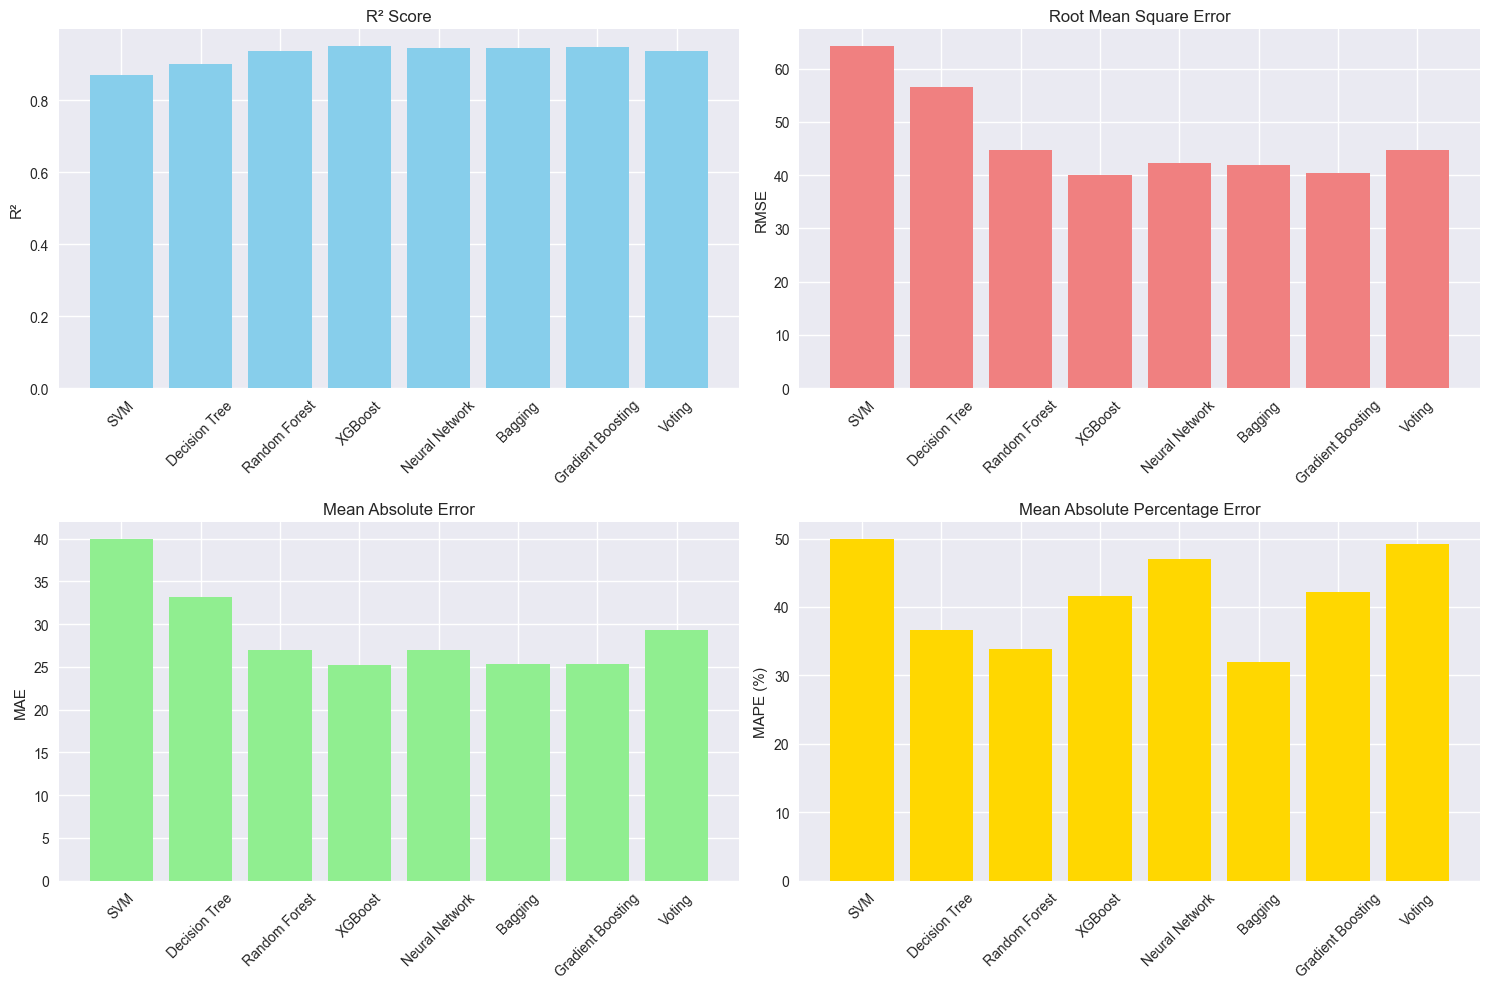

🎯 Generando gráfico de predicciones vs valores reales...


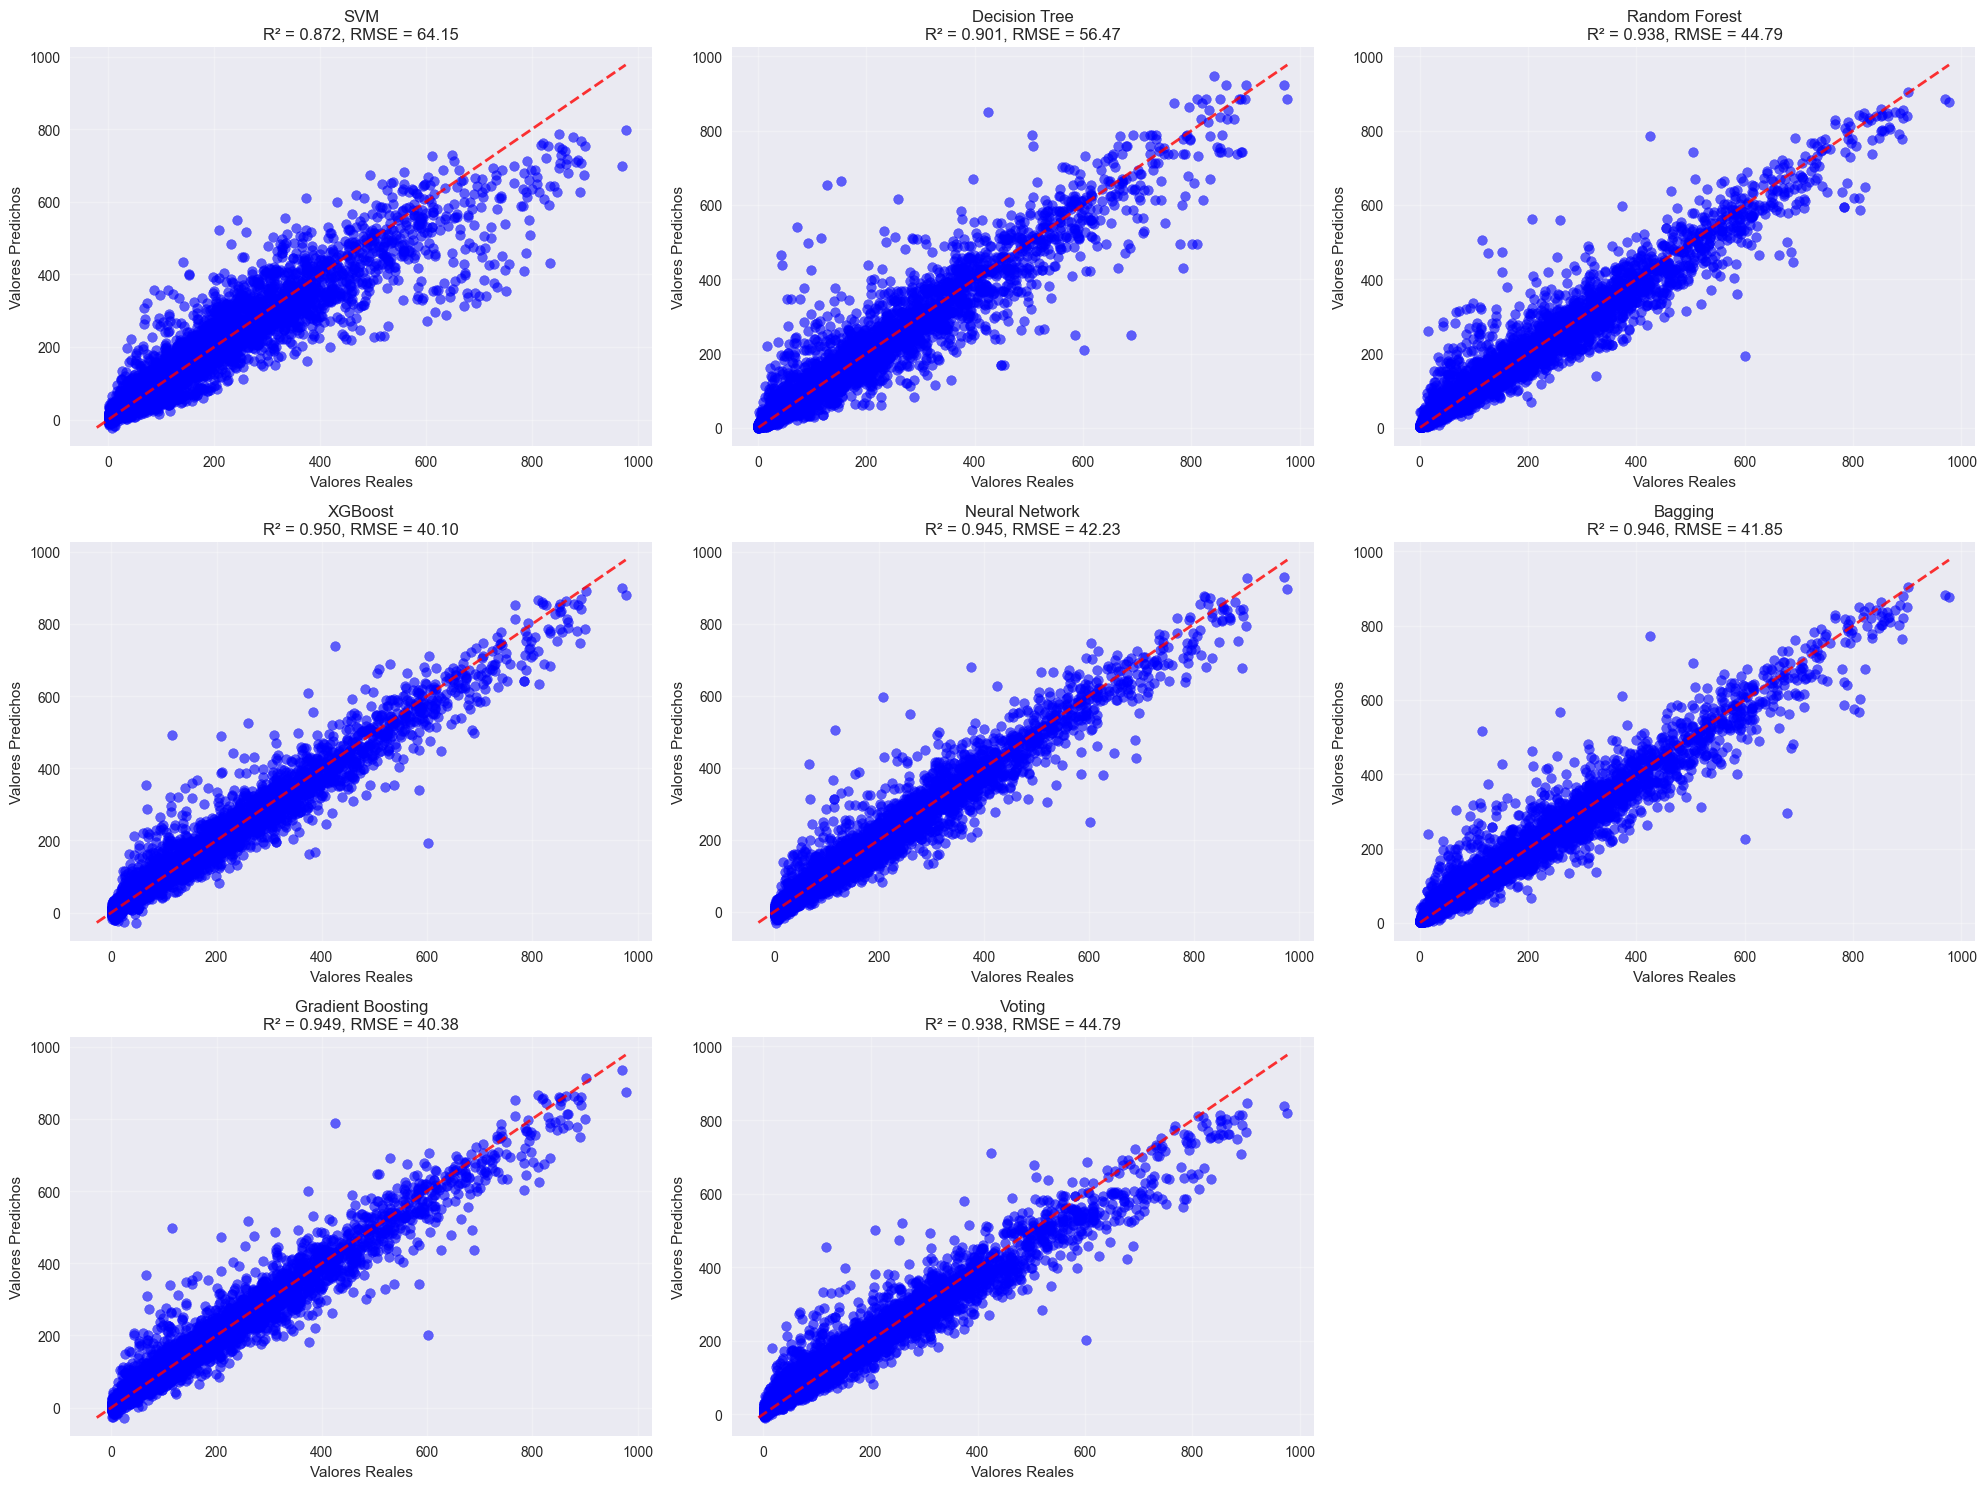

📉 Generando análisis de residuos...


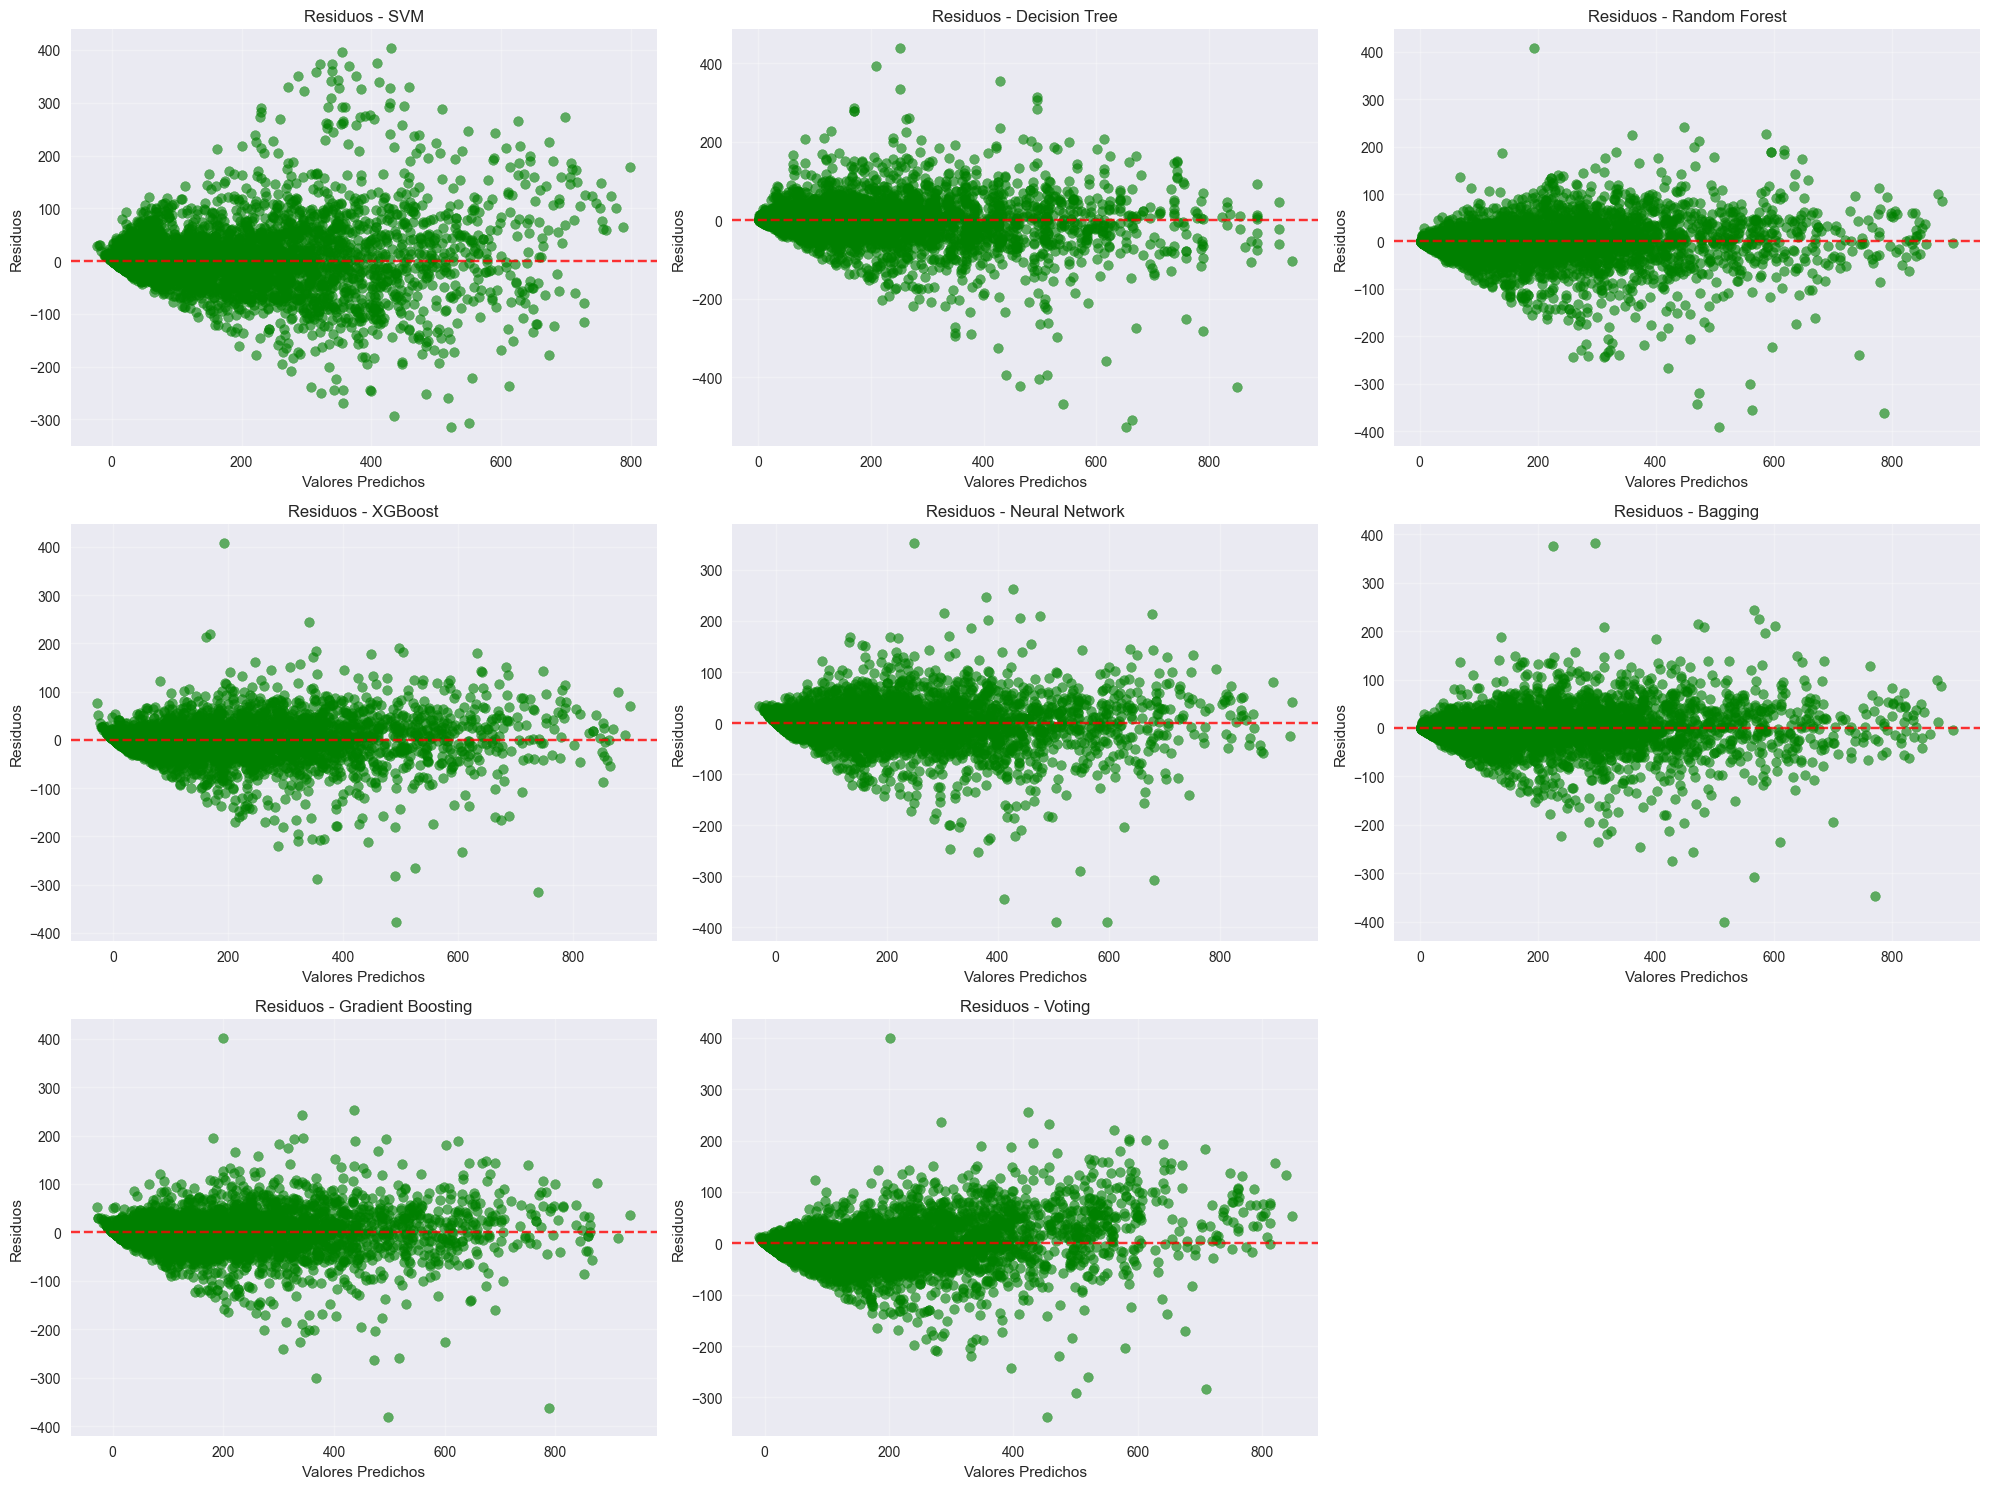

⏱️ Generando gráfico de tiempos de entrenamiento...


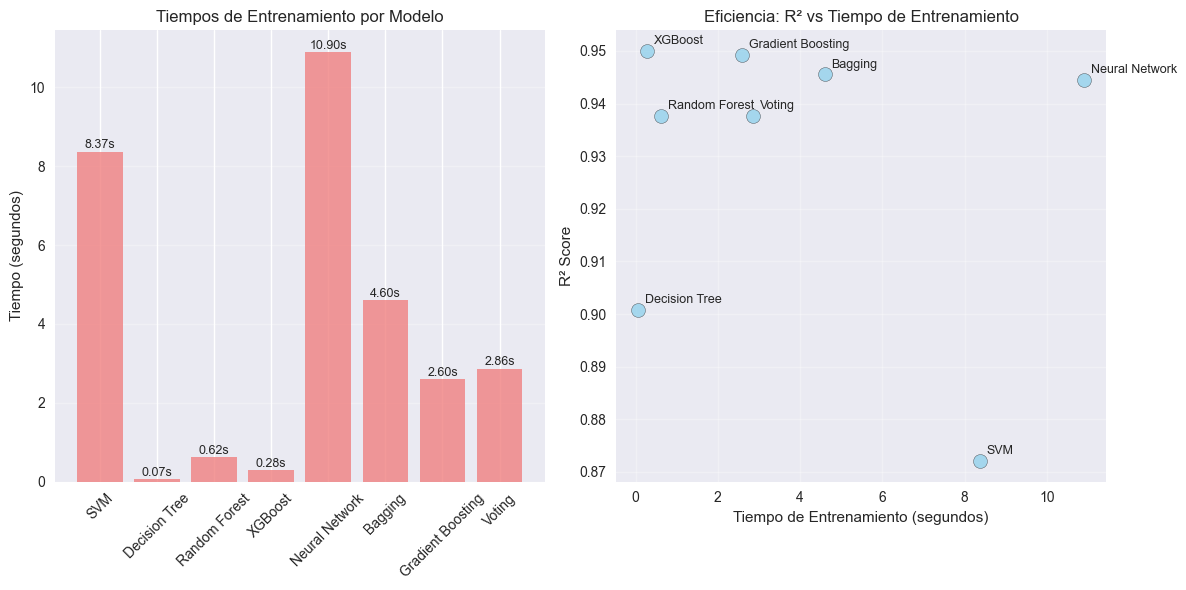


🏆 RANKING FINAL DE MODELOS:
🎖️ RANKING PONDERADO (70% Rendimiento + 30% Velocidad):
1. Decision Tree   | R²: 0.901 | RMSE: 56.47 | Tiempo: 0.07s | Score: 0.964
2. XGBoost         | R²: 0.950 | RMSE: 40.10 | Tiempo: 0.28s | Score: 0.829
3. Random Forest   | R²: 0.938 | RMSE: 44.79 | Tiempo: 0.62s | Score: 0.760
4. Gradient Boosting | R²: 0.949 | RMSE: 40.38 | Tiempo: 2.60s | Score: 0.718
5. Voting          | R²: 0.938 | RMSE: 44.79 | Tiempo: 2.86s | Score: 0.708
6. Bagging         | R²: 0.946 | RMSE: 41.85 | Tiempo: 4.60s | Score: 0.707
7. Neural Network  | R²: 0.945 | RMSE: 42.23 | Tiempo: 10.90s | Score: 0.701
8. SVM             | R²: 0.872 | RMSE: 64.15 | Tiempo: 8.37s | Score: 0.648

🥇 MODELO GANADOR: Decision Tree
   📊 R²: 0.901
   📉 RMSE: 56.47
   ⏱️ Tiempo: 0.07s
   🎯 Score ponderado: 0.964

✅ Evaluación completa terminada!


In [24]:
# 3.5 Visualizaciones Comparativas
print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("=" * 50)

# 1. Gráfico de métricas comparativas
print("📈 Generando gráfico de métricas comparativas...")
metrics_comparison_df = compare_models_metrics(model_results, figsize=(15, 10))

# 2. Gráfico de predicciones vs valores reales
print("🎯 Generando gráfico de predicciones vs valores reales...")
plot_regression_results(model_results, y_test, figsize=(20, 15))

# 3. Análisis de residuos
print("📉 Generando análisis de residuos...")
plot_residuals_analysis(model_results, y_test, figsize=(20, 15))

# 4. Gráfico de tiempos de entrenamiento
print("⏱️ Generando gráfico de tiempos de entrenamiento...")
plt.figure(figsize=(12, 6))
models_names = list(training_times.keys())
times = list(training_times.values())

plt.subplot(1, 2, 1)
bars = plt.bar(models_names, times, color='lightcoral', alpha=0.8)
plt.title('Tiempos de Entrenamiento por Modelo')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.2f}s', ha='center', va='bottom', fontsize=9)

# 5. Gráfico de eficiencia (R² vs Tiempo)
plt.subplot(1, 2, 2)
r2_scores = [model_results[model]['R²'] for model in models_names]
plt.scatter(times, r2_scores, s=100, alpha=0.7, c='skyblue', edgecolor='black')

for i, model in enumerate(models_names):
    plt.annotate(model, (times[i], r2_scores[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=9)

plt.xlabel('Tiempo de Entrenamiento (segundos)')
plt.ylabel('R² Score')
plt.title('Eficiencia: R² vs Tiempo de Entrenamiento')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Ranking final de modelos
print("\n🏆 RANKING FINAL DE MODELOS:")
print("=" * 50)

# Crear ranking ponderado (70% rendimiento, 30% velocidad)
ranking_data = []
for model_name in models_names:
    r2_score = model_results[model_name]['R²']
    time_score = 1 / (training_times[model_name] + 0.1)  # Inverso del tiempo
    
    # Normalizar scores
    r2_norm = r2_score / max(r2_scores)
    time_norm = time_score / max([1 / (t + 0.1) for t in times])
    
    # Score ponderado
    weighted_score = 0.7 * r2_norm + 0.3 * time_norm
    
    ranking_data.append({
        'Modelo': model_name,
        'R²': r2_score,
        'RMSE': model_results[model_name]['RMSE'],
        'MAE': model_results[model_name]['MAE'],
        'Tiempo': training_times[model_name],
        'Score_Ponderado': weighted_score
    })

# Ordenar por score ponderado
ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Score_Ponderado', ascending=False)

print("🎖️ RANKING PONDERADO (70% Rendimiento + 30% Velocidad):")
for i, (_, row) in enumerate(ranking_df.iterrows(), 1):
    print(f"{i}. {row['Modelo']:<15} | R²: {row['R²']:.3f} | RMSE: {row['RMSE']:.2f} | Tiempo: {row['Tiempo']:.2f}s | Score: {row['Score_Ponderado']:.3f}")

# Guardar el mejor modelo
best_model_final = ranking_df.iloc[0]['Modelo']
best_model_obj = models[best_model_final]

print(f"\n🥇 MODELO GANADOR: {best_model_final}")
print(f"   📊 R²: {ranking_df.iloc[0]['R²']:.3f}")
print(f"   📉 RMSE: {ranking_df.iloc[0]['RMSE']:.2f}")
print(f"   ⏱️ Tiempo: {ranking_df.iloc[0]['Tiempo']:.2f}s")
print(f"   🎯 Score ponderado: {ranking_df.iloc[0]['Score_Ponderado']:.3f}")

print(f"\n✅ Evaluación completa terminada!")

## 3.5 Cross Validation de Todos los Modelos

### 🔄 **Validación Cruzada Completa**
Realizaremos validación cruzada con K-Fold (k=5) para evaluar la robustez y generalización de todos los modelos entrenados. Esto nos permitirá:

- **Evaluar la estabilidad** de cada modelo
- **Detectar overfitting/underfitting**
- **Comparar el rendimiento promedio** y la variabilidad
- **Obtener intervalos de confianza** para las métricas

In [29]:
# 3.5 Cross Validation de Todos los Modelos
print("🔄 CROSS VALIDATION DE TODOS LOS MODELOS")
print("=" * 60)

from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time_module

# Configurar K-Fold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

print(f"📋 Configuración de Cross Validation:")
print(f"  • Método: K-Fold")
print(f"  • Número de folds: {k_folds}")
print(f"  • Semilla aleatoria: {SEED}")
print(f"  • Dataset completo: {X.shape[0]} registros")

# Métricas a evaluar
scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Definir modelos para cross validation (recreamos para evitar problemas)
print(f"\n🤖 Modelos a evaluar:")

cv_models = {
    'SVM': SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, 
                                         min_samples_leaf=5, random_state=SEED, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                              subsample=0.8, colsample_bytree=0.8, random_state=SEED, n_jobs=-1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, alpha=0.01, 
                                 random_state=SEED, early_stopping=True, validation_fraction=0.1),
    'Bagging': BaggingRegressor(n_estimators=100, random_state=SEED, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                                 min_samples_split=10, min_samples_leaf=5, random_state=SEED),
    'Voting': VotingRegressor([
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=SEED)),
        ('xgb', xgb.XGBRegressor(n_estimators=50, max_depth=6, random_state=SEED)),
        ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=SEED))
    ], n_jobs=-1)
}

for i, model_name in enumerate(cv_models.keys(), 1):
    print(f"  {i}. {model_name}")

# Preparar datasets para CV usando el escalado selectivo ya aplicado
print(f"\n? PREPARANDO DATASETS PARA CROSS VALIDATION:")
print(f"  • Variables escaladas: {num_feats}")
print(f"  • Variables no escaladas: {len([col for col in X.columns if col not in num_feats])} variables")

# Crear dataset completo con escalado selectivo para CV
# Reconstruir el scaler con todo el dataset (esto es válido para CV)
scaler_cv = StandardScaler()
X_cv_scaled = X.copy()
X_cv_scaled[num_feats] = scaler_cv.fit_transform(X[num_feats])
y_cv = y

print(f"  ✅ Dataset para CV preparado correctamente")

# Almacenar resultados de CV
cv_results = {}
cv_times = {}

print(f"\n🚀 Iniciando Cross Validation...")
print("=" * 60)

# Realizar cross validation para cada modelo
for model_name, model in cv_models.items():
    print(f"\n🔄 Cross Validation - {model_name}")
    print("-" * 40)
    
    start_time = time_module.time()
    
    try:
        # Determinar si usar datos escalados o no
        if model_name in ['SVM', 'Neural Network']:
            # Para modelos que necesitan escalado, usar dataset con escalado selectivo
            X_cv_model = X_cv_scaled
            print(f"  📊 Usando datos con escalado selectivo")
        else:
            # Para otros modelos, usar datos originales
            X_cv_model = X
            print(f"  📊 Usando datos originales")
        
        # Realizar cross validation
        cv_scores = cross_validate(
            model, X_cv_model, y_cv, 
            cv=kfold, 
            scoring=scoring_metrics,
            return_train_score=True,
            n_jobs=-1
        )
        
        # Calcular métricas
        r2_scores = cv_scores['test_r2']
        rmse_scores = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
        mae_scores = -cv_scores['test_neg_mean_absolute_error']
        
        # Guardar resultados
        cv_results[model_name] = {
            'R²_scores': r2_scores,
            'RMSE_scores': rmse_scores,
            'MAE_scores': mae_scores,
            'R²_mean': np.mean(r2_scores),
            'R²_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores),
            'MAE_mean': np.mean(mae_scores),
            'MAE_std': np.std(mae_scores),
            'train_r2_mean': np.mean(cv_scores['train_r2']),
            'train_r2_std': np.std(cv_scores['train_r2'])
        }
        
        cv_times[model_name] = time_module.time() - start_time
        
        # Mostrar resultados
        print(f"  ✅ Completado en {cv_times[model_name]:.2f}s")
        print(f"  📊 R² = {cv_results[model_name]['R²_mean']:.4f} ± {cv_results[model_name]['R²_std']:.4f}")
        print(f"  📊 RMSE = {cv_results[model_name]['RMSE_mean']:.2f} ± {cv_results[model_name]['RMSE_std']:.2f}")
        print(f"  📊 MAE = {cv_results[model_name]['MAE_mean']:.2f} ± {cv_results[model_name]['MAE_std']:.2f}")
        
        # Detectar overfitting
        train_test_diff = cv_results[model_name]['train_r2_mean'] - cv_results[model_name]['R²_mean']
        if train_test_diff > 0.1:
            print(f"  ⚠️  Posible overfitting detectado (diff: {train_test_diff:.3f})")
        elif train_test_diff < 0.05:
            print(f"  ✅ Buena generalización (diff: {train_test_diff:.3f})")
        else:
            print(f"  📊 Generalización moderada (diff: {train_test_diff:.3f})")
            
    except Exception as e:
        print(f"  ❌ Error en {model_name}: {str(e)}")
        cv_results[model_name] = None

print(f"\n🎉 Cross Validation completada!")
print(f"⏱️ Tiempo total: {sum(cv_times.values()):.2f} segundos")

🔄 CROSS VALIDATION DE TODOS LOS MODELOS
📋 Configuración de Cross Validation:
  • Método: K-Fold
  • Número de folds: 5
  • Semilla aleatoria: 42
  • Dataset completo: 17379 registros

🤖 Modelos a evaluar:
  1. SVM
  2. Decision Tree
  3. Random Forest
  4. XGBoost
  5. Neural Network
  6. Bagging
  7. Gradient Boosting
  8. Voting

🚀 Iniciando Cross Validation...

🔄 Cross Validation - SVM
----------------------------------------
  📊 Usando Pipeline con escalado
  ✅ Completado en 25.82s
  📊 R² = 0.8997 ± 0.0048
  📊 RMSE = 57.42 ± 1.66
  📊 MAE = 35.01 ± 1.04
  ✅ Buena generalización (diff: 0.010)

🔄 Cross Validation - Decision Tree
----------------------------------------
  📊 Usando datos originales
  ✅ Completado en 25.82s
  📊 R² = 0.8997 ± 0.0048
  📊 RMSE = 57.42 ± 1.66
  📊 MAE = 35.01 ± 1.04
  ✅ Buena generalización (diff: 0.010)

🔄 Cross Validation - Decision Tree
----------------------------------------
  📊 Usando datos originales
  ✅ Completado en 1.49s
  📊 R² = 0.9117 ± 0.0066
  📊

In [30]:
# Crear tabla comparativa de Cross Validation
print("\n📊 TABLA COMPARATIVA - CROSS VALIDATION RESULTS")
print("=" * 80)

# Crear DataFrame con resultados de CV
cv_summary = []
for model_name, results in cv_results.items():
    if results is not None:
        cv_summary.append({
            'Modelo': model_name,
            'R² Mean': results['R²_mean'],
            'R² Std': results['R²_std'],
            'RMSE Mean': results['RMSE_mean'],
            'RMSE Std': results['RMSE_std'],
            'MAE Mean': results['MAE_mean'],
            'MAE Std': results['MAE_std'],
            'Train R²': results['train_r2_mean'],
            'Overfitting': results['train_r2_mean'] - results['R²_mean'],
            'CV Time (s)': cv_times[model_name]
        })

cv_df = pd.DataFrame(cv_summary)
cv_df = cv_df.sort_values('R² Mean', ascending=False)

# Mostrar tabla
print(cv_df.round(4).to_string(index=False))

# Identificar el mejor modelo según CV
best_cv_model = cv_df.iloc[0]
print(f"\n🏆 MEJOR MODELO SEGÚN CROSS VALIDATION:")
print(f"  🥇 Modelo: {best_cv_model['Modelo']}")
print(f"  📊 R² Promedio: {best_cv_model['R² Mean']:.4f} ± {best_cv_model['R² Std']:.4f}")
print(f"  📊 RMSE Promedio: {best_cv_model['RMSE Mean']:.2f} ± {best_cv_model['RMSE Std']:.2f}")
print(f"  📊 Estabilidad: {'Alta' if best_cv_model['R² Std'] < 0.02 else 'Moderada' if best_cv_model['R² Std'] < 0.05 else 'Baja'}")
print(f"  📊 Overfitting: {'Bajo' if best_cv_model['Overfitting'] < 0.05 else 'Moderado' if best_cv_model['Overfitting'] < 0.1 else 'Alto'}")

# Análisis de estabilidad
print(f"\n📈 ANÁLISIS DE ESTABILIDAD:")
stable_models = cv_df[cv_df['R² Std'] < 0.03]['Modelo'].tolist()
unstable_models = cv_df[cv_df['R² Std'] >= 0.05]['Modelo'].tolist()

print(f"  ✅ Modelos Estables (R² Std < 0.03): {stable_models if stable_models else 'Ninguno'}")
print(f"  ⚠️  Modelos Inestables (R² Std >= 0.05): {unstable_models if unstable_models else 'Ninguno'}")

# Análisis de overfitting
print(f"\n🎯 ANÁLISIS DE OVERFITTING:")
good_generalization = cv_df[cv_df['Overfitting'] < 0.05]['Modelo'].tolist()
overfitting_models = cv_df[cv_df['Overfitting'] >= 0.1]['Modelo'].tolist()

print(f"  ✅ Buena Generalización (diff < 0.05): {good_generalization if good_generalization else 'Ninguno'}")
print(f"  ❌ Posible Overfitting (diff >= 0.1): {overfitting_models if overfitting_models else 'Ninguno'}")

# Ranking final considerando múltiples criterios
print(f"\n🏅 RANKING FINAL (Cross Validation):")
cv_df['Score_CV'] = (
    cv_df['R² Mean'] * 0.4 +  # 40% peso en R²
    (1 - cv_df['R² Std'] / cv_df['R² Std'].max()) * 0.3 +  # 30% peso en estabilidad
    (1 - cv_df['Overfitting'] / cv_df['Overfitting'].max()) * 0.3  # 30% peso anti-overfitting
)

cv_df_ranked = cv_df.sort_values('Score_CV', ascending=False)

for i, (_, row) in enumerate(cv_df_ranked.head().iterrows(), 1):
    print(f"  {i}. {row['Modelo']} - Score: {row['Score_CV']:.3f}")
    print(f"     R²: {row['R² Mean']:.4f}±{row['R² Std']:.4f}, RMSE: {row['RMSE Mean']:.2f}±{row['RMSE Std']:.2f}")


📊 TABLA COMPARATIVA - CROSS VALIDATION RESULTS
           Modelo  R² Mean  R² Std  RMSE Mean  RMSE Std  MAE Mean  MAE Std  Train R²  Overfitting  CV Time (s)
Gradient Boosting   0.9497  0.0032    40.6494    1.1778   25.5784   0.8582    0.9681       0.0184       3.4150
          XGBoost   0.9496  0.0026    40.6937    1.0335   25.6518   0.7818    0.9675       0.0179       0.7796
          Bagging   0.9468  0.0029    41.7841    0.8869   25.2573   0.4793    0.9924       0.0456       5.0355
   Neural Network   0.9439  0.0042    42.9038    1.4489   28.1264   1.1704    0.9545       0.0106       9.7228
    Random Forest   0.9400  0.0038    44.3873    0.9843   26.7596   0.5340    0.9678       0.0279       3.8866
           Voting   0.9372  0.0031    45.4255    1.0177   29.6940   0.8107    0.9622       0.0250       3.8160
    Decision Tree   0.9117  0.0066    53.8006    1.3183   32.1046   0.4100    0.9650       0.0532       1.4930
              SVM   0.8997  0.0048    57.4227    1.6583   35.006


📊 VISUALIZACIONES DE CROSS VALIDATION


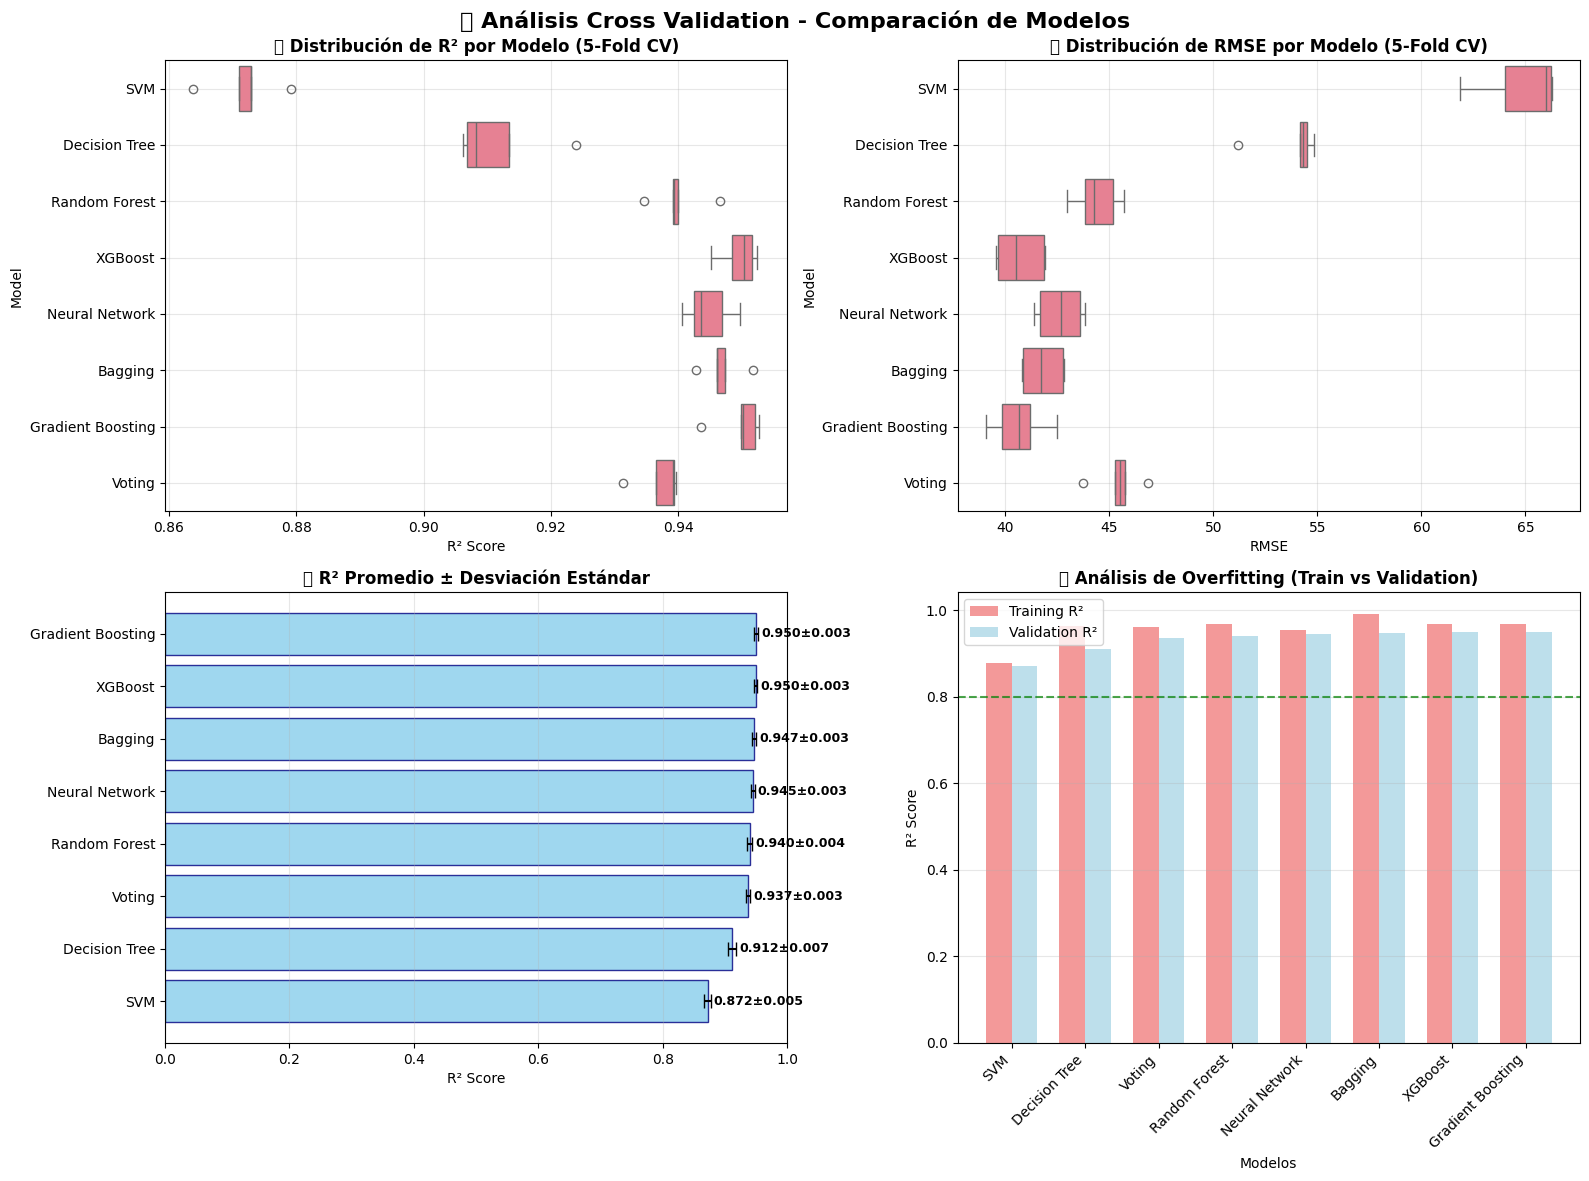


📈 ESTADÍSTICAS ADICIONALES:
  📊 Mejor R² promedio: 0.9497 (Gradient Boosting)
  📊 Menor RMSE promedio: 40.65 (Gradient Boosting)
  📊 Mayor estabilidad: XGBoost (R² Std: 0.0026)
  📊 Menor overfitting: SVM (diff: 0.0059)

✅ Cross Validation completado exitosamente!


In [27]:
# Visualizaciones de Cross Validation
print("\n📊 VISUALIZACIONES DE CROSS VALIDATION")
print("=" * 50)

# Configurar el estilo de las gráficas
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Análisis Cross Validation - Comparación de Modelos', fontsize=16, fontweight='bold')

# 1. Box plot de R² scores
ax1 = axes[0, 0]
r2_data = []
model_names = []
for model_name, results in cv_results.items():
    if results is not None:
        r2_data.extend(results['R²_scores'])
        model_names.extend([model_name] * len(results['R²_scores']))

cv_viz_df = pd.DataFrame({'Model': model_names, 'R²': r2_data})
sns.boxplot(data=cv_viz_df, y='Model', x='R²', ax=ax1)
ax1.set_title('📊 Distribución de R² por Modelo (5-Fold CV)', fontweight='bold')
ax1.set_xlabel('R² Score')
ax1.grid(True, alpha=0.3)

# 2. Box plot de RMSE scores
ax2 = axes[0, 1]
rmse_data = []
model_names = []
for model_name, results in cv_results.items():
    if results is not None:
        rmse_data.extend(results['RMSE_scores'])
        model_names.extend([model_name] * len(results['RMSE_scores']))

rmse_viz_df = pd.DataFrame({'Model': model_names, 'RMSE': rmse_data})
sns.boxplot(data=rmse_viz_df, y='Model', x='RMSE', ax=ax2)
ax2.set_title('📊 Distribución de RMSE por Modelo (5-Fold CV)', fontweight='bold')
ax2.set_xlabel('RMSE')
ax2.grid(True, alpha=0.3)

# 3. Gráfico de barras con intervalos de confianza - R²
ax3 = axes[1, 0]
models_sorted = cv_df.sort_values('R² Mean', ascending=True)
y_pos = np.arange(len(models_sorted))

bars = ax3.barh(y_pos, models_sorted['R² Mean'], 
                xerr=models_sorted['R² Std'], 
                capsize=5, alpha=0.8, color='skyblue', edgecolor='navy')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(models_sorted['Modelo'])
ax3.set_xlabel('R² Score')
ax3.set_title('📈 R² Promedio ± Desviación Estándar', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, value, std) in enumerate(zip(bars, models_sorted['R² Mean'], models_sorted['R² Std'])):
    ax3.text(value + std + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}±{std:.3f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 4. Análisis de Overfitting
ax4 = axes[1, 1]
train_r2 = [cv_results[model]['train_r2_mean'] for model in models_sorted['Modelo'] if cv_results[model] is not None]
test_r2 = models_sorted['R² Mean'].values

x_pos = np.arange(len(models_sorted))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, train_r2, width, label='Training R²', alpha=0.8, color='lightcoral')
bars2 = ax4.bar(x_pos + width/2, test_r2, width, label='Validation R²', alpha=0.8, color='lightblue')

ax4.set_xlabel('Modelos')
ax4.set_ylabel('R² Score')
ax4.set_title('🎯 Análisis de Overfitting (Train vs Validation)', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models_sorted['Modelo'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Línea de referencia
ax4.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Target R²=0.8')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n📈 ESTADÍSTICAS ADICIONALES:")
print(f"  📊 Mejor R² promedio: {cv_df['R² Mean'].max():.4f} ({cv_df.loc[cv_df['R² Mean'].idxmax(), 'Modelo']})")
print(f"  📊 Menor RMSE promedio: {cv_df['RMSE Mean'].min():.2f} ({cv_df.loc[cv_df['RMSE Mean'].idxmin(), 'Modelo']})")
print(f"  📊 Mayor estabilidad: {cv_df.loc[cv_df['R² Std'].idxmin(), 'Modelo']} (R² Std: {cv_df['R² Std'].min():.4f})")
print(f"  📊 Menor overfitting: {cv_df.loc[cv_df['Overfitting'].idxmin(), 'Modelo']} (diff: {cv_df['Overfitting'].min():.4f})")

print(f"\n✅ Cross Validation completado exitosamente!")